In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,753 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126308 files and dire

# 1. 데이터

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
plt.rc('font', family='NanumBarunGothic')
drive.mount('/content/drive')

In [ ]:
final= pd.read_csv('/content/drive/MyDrive/DScover/메인프로젝트/메인프로젝트/Main/final_r1.csv', encoding='cp949')

In [ ]:
# object -> numeric
final['output_index'] = pd.to_numeric(final['output_index'], errors='coerce')
final['labor_productivity_index'] = pd.to_numeric(final['labor_productivity_index'], errors='coerce')

# 2. 더미변수 생성 - PCA 사용

- 지역별 학습


#### feature engineering

In [ ]:
final = final.sort_values(['sido', 'industry_code', 'base_year_x'])

# 증감률 계산
final['n_ent_growth'] = final.groupby(['sido', 'industry_code'])['n_ent'].pct_change() * 100
final['employment_growth'] = final.groupby(['sido', 'industry_code'])['employment_thousand'].pct_change() * 100


# 증감률 계산시 발생하는 inf에 대한 처리 (분모가 0일때 발생하는 문제로, NaN으로 처리)
# n_ent==0인 경우는 없음. employmet_thousand==0인 경우 존재
final['n_ent_growth'].replace([np.inf, -np.inf], np.nan, inplace=True)
final['employment_growth'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 76번 산업에서 output_index 또는 labor_productivity_index가 0인 행들 찾기
target_mask = (
    (final["industry_code"] == 76) &
    ((final["output_index"] == 0) | (final["labor_productivity_index"] == 0))
)
target_rows = final[target_mask]

# 각 해당 행마다 base_year_x와 sido가 같은 68번 산업의 값으로 대체
for idx, row in target_rows.iterrows():
    year_val = row["base_year_x"]
    sido_val = row["sido"]

    # 68번 산업, 동일 시점 및 지역의 값 찾기
    ref_row = final[
        (final["industry_code"] == 68) &
        (final["base_year_x"] == year_val) &
        (final["sido"] == sido_val)
    ]

    if not ref_row.empty:
        if final.loc[idx, "output_index"] == 0:
            final.loc[idx, "output_index"] = ref_row.iloc[0]["output_index"]
        if final.loc[idx, "labor_productivity_index"] == 0:
            final.loc[idx, "labor_productivity_index"] = ref_row.iloc[0]["labor_productivity_index"]


target_cols = ['n_ent', 'avg_ent_wker',
       'med_ent_wker', 'avg_ent_sls', 'med_ent_sls', 'avg_ent_tdwrkr',
       'med_ent_tdwrkr', 'n_people', 'avg_age', 'med_age', 'avg_income',
       'med_income', 'output_index', 'labor_productivity_index',
       'nominal_value_added', 'employment_thousand','n_ent_growth','employment_growth']

# 지역별 + 산업별 그룹 단위로 결측치 채우기
for col in target_cols:
    final[col] = final.groupby(['sido', 'industry_code'])[col].transform(
        lambda x: x.fillna(x.median())
    )

    final[col] = final.groupby('sido')[col].transform(
        lambda x: x.fillna(x.median()))


# 기업체 수 및 고용 관련 파생 변수 (이전 값이 NaN인 경우, 다른 값들도 NaN로 생성되는 문제 해결)
final['n_ent_prev'] = final.groupby(['sido', 'industry_code'])['n_ent'].shift(1).fillna(0)
final['employment_prev'] = final.groupby(['sido', 'industry_code'])['employment_thousand'].shift(1).fillna(0)

# 기타 플래그
# 0->상수 반영(증감률)이 불가한 상황 보완
final['is_new_industry'] = ((final['n_ent_prev'] == 0) & (final['n_ent'] > 0)).astype(int)
final['is_disappeared_industry'] = ((final['n_ent_prev'] > 0) & (final['n_ent'] == 0)).astype(int)
final['employment_change'] = final['employment_thousand'] - final['employment_prev']
final['is_new_employment_generated'] = (final['employment_thousand'] > 0).astype(int)
final['employment_disappeared'] = ((final['employment_prev'] > 0) & (final['employment_thousand'] == 0)).astype(int)



/tmp/ipython-input-6-3883250351.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final['n_ent_growth'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-6-3883250351.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

In [ ]:
from sklearn.decomposition import PCA
pca_features = ['n_ent_growth','output_index','labor_productivity_index']
# pca_features = ['n_ent_growth', 'employment_growth','output_index','labor_productivity_index']

# PCA 대상 데이터만 추출
pca_data = final[pca_features]

# 정규화
scaler = StandardScaler()
pca_scaled = scaler.fit_transform(pca_data)

# PCA 적용
pca = PCA(n_components=1)
final['composite_decline_index'] = pca.fit_transform(pca_scaled).flatten()

# 설명력 확인 (선택)
explained_ratio = pca.explained_variance_ratio_[0]
print(f'첫 번째 주성분 설명력: {explained_ratio:.4f}')


첫 번째 주성분 설명력: 0.6237


# 3. ML

- 지역 구분 학습 - 지역별 사양산업 파악

In [ ]:
# 연도, 분기
final['year'] = final['base_year_x'] // 10
final['quarter'] = final['base_year_x'] % 10

# final['quarter_sin'] = np.sin(2 * np.pi * final['quarter'] / 4)
# final['quarter_cos'] = np.cos(2 * np.pi * final['quarter'] / 4)

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


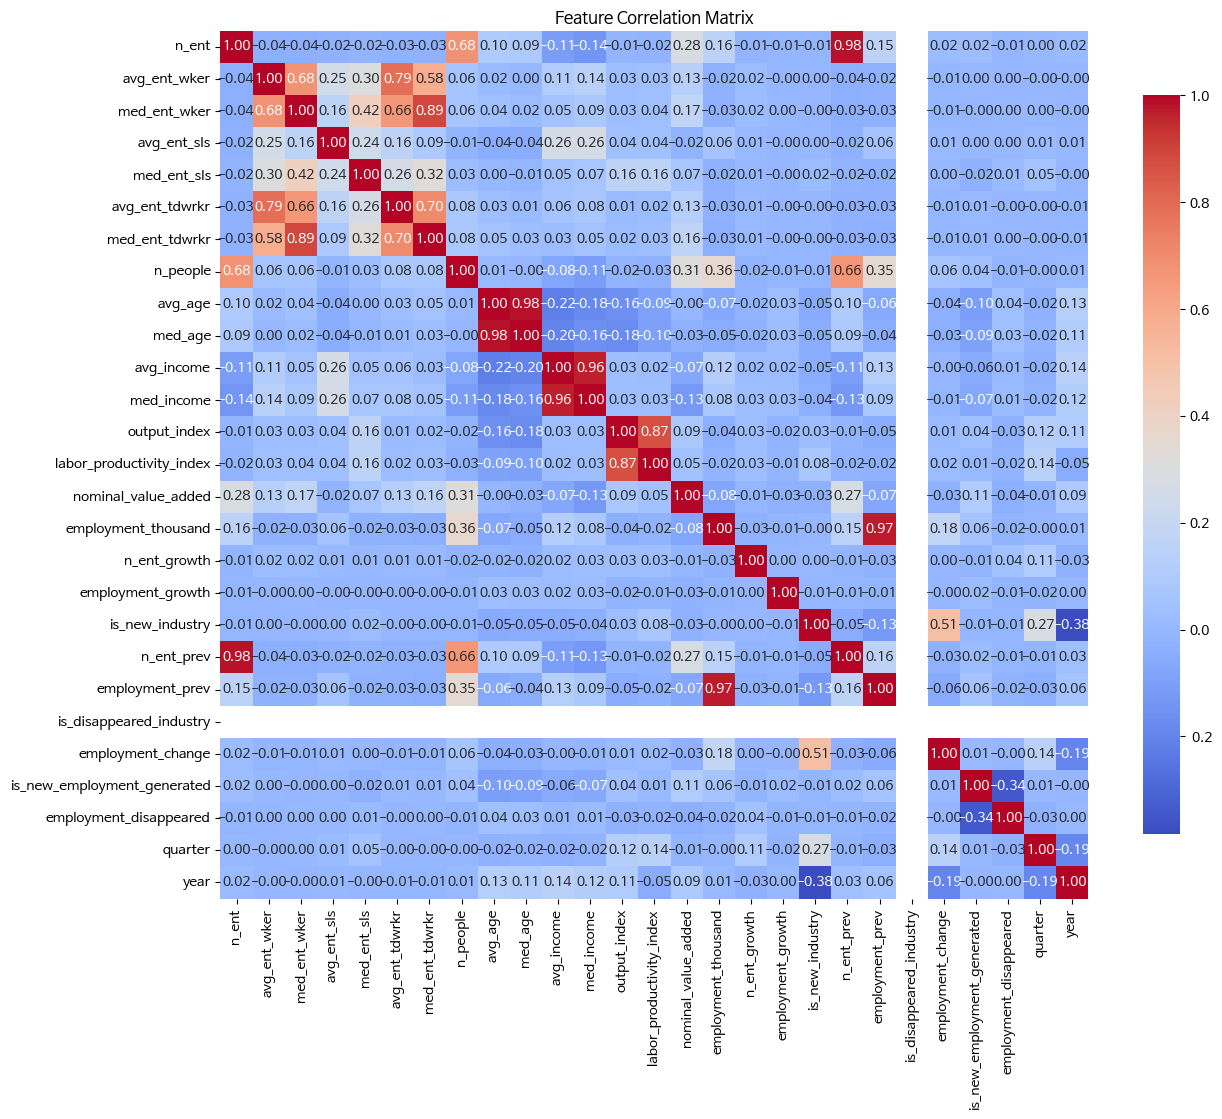

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 분석할 feature 리스트
features = ['n_ent', 'avg_ent_wker', 'med_ent_wker', 'avg_ent_sls', 'med_ent_sls',
            'avg_ent_tdwrkr', 'med_ent_tdwrkr', 'n_people', 'avg_age', 'med_age',
            'avg_income', 'med_income', 'output_index', 'labor_productivity_index',
            'nominal_value_added', 'employment_thousand', 'n_ent_growth',
            'employment_growth', 'is_new_industry','n_ent_prev', 'employment_prev',
            'is_disappeared_industry', 'employment_change', 'is_new_employment_generated',
            'employment_disappeared','quarter','year']

# 상관계수 계산 (피어슨 상관계수)
corr_matrix = final[features].corr()

# 히트맵 그리기
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.show()


In [ ]:
final = final.drop(['n_ent_prev', 'employment_prev'], axis=1)


==== 지역: 강원도 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3853
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 56
[LightGBM] [Info] Start training from score 0.005314


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 1429, number of used features: 56
[LightGBM] [Info] Start training from score -0.013764
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3844
[LightGBM] [Info] Number of data points in the train set: 1429, number of used features: 53
[LightGBM] [Info] Start training from score 0.024582


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3835
[LightGBM] [Info] Number of data points in the train set: 1429, number of used features: 53
[LightGBM] [Info] Start training from score 0.012312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3835
[LightGBM] [Info] Number of data points in the train set: 1429, number of used features: 54
[LightGBM] [Info] Start training from score 0.012869


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Cross-validated R2: 0.9100 ± 0.0361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4043
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 94
[LightGBM] [Info] Start training from score 0.008263


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


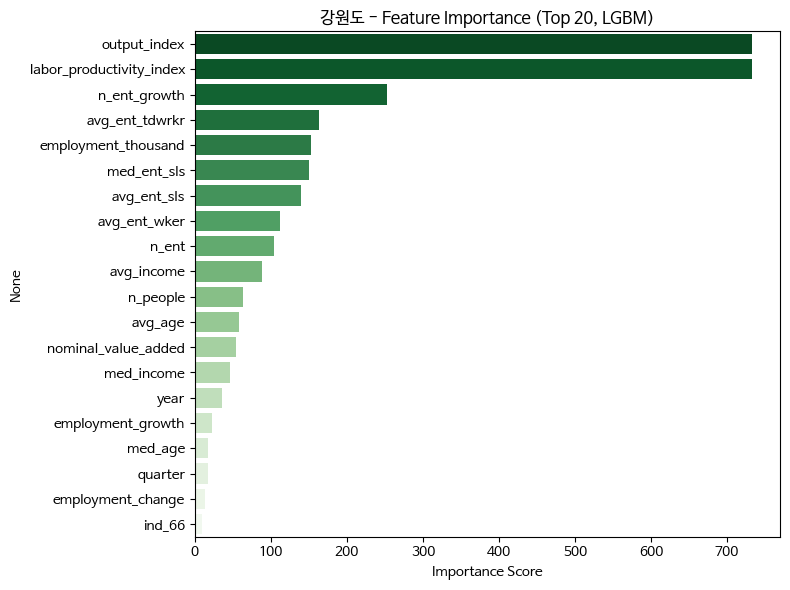


==== 지역: 경기도 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3823
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 56
[LightGBM] [Info] Start training from score 0.004054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3822
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 55
[LightGBM] [Info] Start training from score 0.008909


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 54
[LightGBM] [Info] Start training from score -0.006559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3816
[LightGBM] [Info] Number of data points in the train set: 1459, number of used features: 53
[LightGBM] [Info] Start training from score 0.017069


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3840
[LightGBM] [Info] Number of data points in the train set: 1459, number of used features: 61
[LightGBM] [Info] Start training from score -0.016232
✅ Cross-validated R2: 0.9570 ± 0.0106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4018
[LightGBM] [Info] Number of data points in the train set: 1823, number of used features: 96
[LightGBM] [Info] Start training from score 0.001448


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


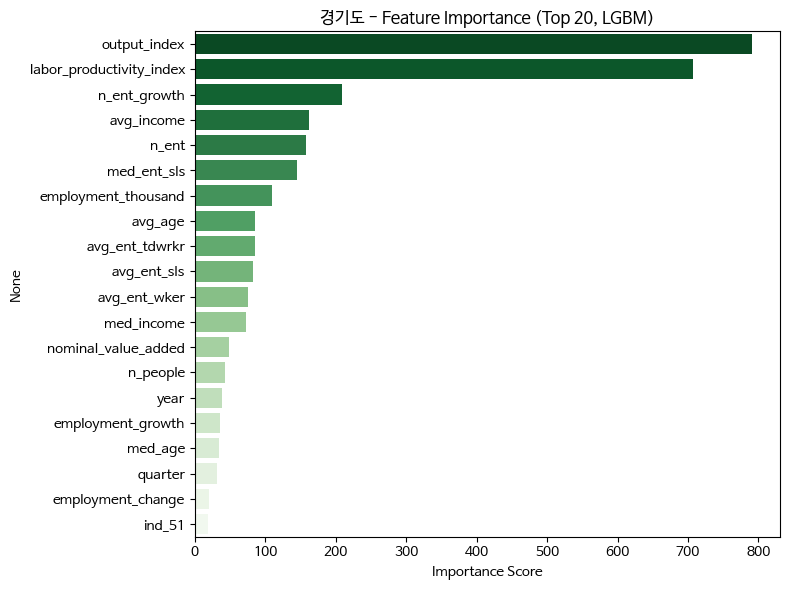


==== 지역: 경상남도 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3822
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 54
[LightGBM] [Info] Start training from score 0.027797


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3836
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 56
[LightGBM] [Info] Start training from score 0.014220


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3831
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 55
[LightGBM] [Info] Start training from score 0.000306


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3830
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 56
[LightGBM] [Info] Start training from score -0.012167


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3846
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 60
[LightGBM] [Info] Start training from score -0.003872


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Cross-validated R2: 0.9364 ± 0.0283
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4026
[LightGBM] [Info] Number of data points in the train set: 1820, number of used features: 96
[LightGBM] [Info] Start training from score 0.005257


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


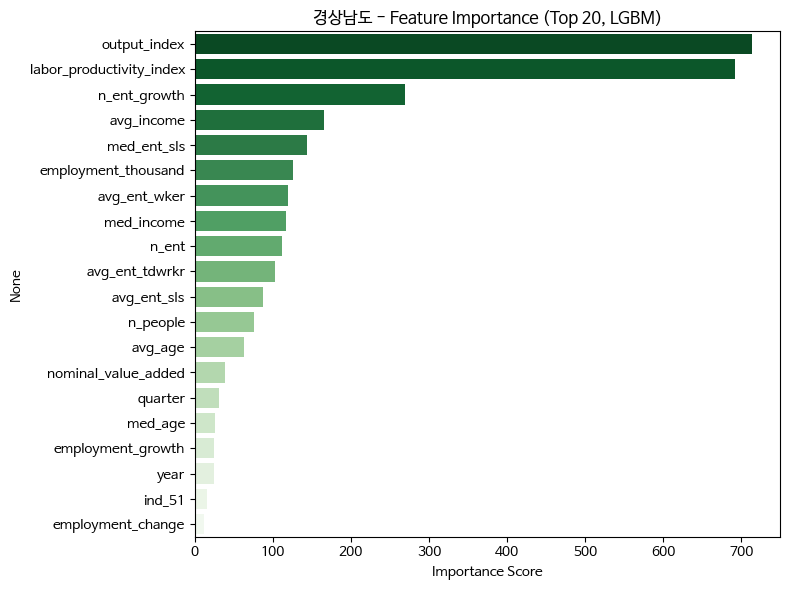


==== 지역: 경상북도 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3808
[LightGBM] [Info] Number of data points in the train set: 1415, number of used features: 50
[LightGBM] [Info] Start training from score 0.011742


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3829
[LightGBM] [Info] Number of data points in the train set: 1415, number of used features: 54
[LightGBM] [Info] Start training from score 0.023255


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3814
[LightGBM] [Info] Number of data points in the train set: 1415, number of used features: 51
[LightGBM] [Info] Start training from score 0.024632


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3805
[LightGBM] [Info] Number of data points in the train set: 1415, number of used features: 52
[LightGBM] [Info] Start training from score 0.007385


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3832
[LightGBM] [Info] Number of data points in the train set: 1416, number of used features: 54
[LightGBM] [Info] Start training from score 0.007795


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Cross-validated R2: 0.9436 ± 0.0149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4013
[LightGBM] [Info] Number of data points in the train set: 1769, number of used features: 93
[LightGBM] [Info] Start training from score 0.014961


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


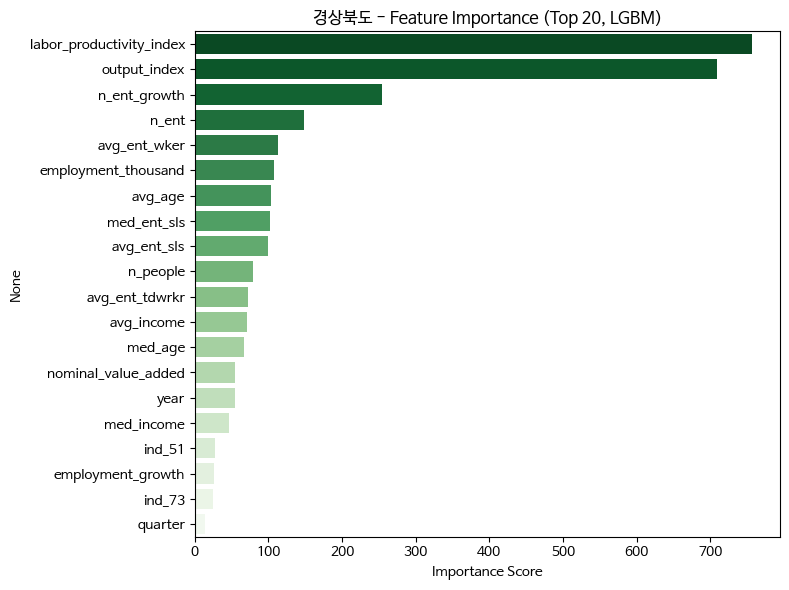


==== 지역: 광주광역시 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3794
[LightGBM] [Info] Number of data points in the train set: 1382, number of used features: 48
[LightGBM] [Info] Start training from score -0.045724


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3807
[LightGBM] [Info] Number of data points in the train set: 1382, number of used features: 52
[LightGBM] [Info] Start training from score -0.048665


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3809
[LightGBM] [Info] Number of data points in the train set: 1382, number of used features: 50
[LightGBM] [Info] Start training from score -0.045125


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3801
[LightGBM] [Info] Number of data points in the train set: 1383, number of used features: 49
[LightGBM] [Info] Start training from score -0.036144


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3830
[LightGBM] [Info] Number of data points in the train set: 1383, number of used features: 58
[LightGBM] [Info] Start training from score -0.054979


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Cross-validated R2: 0.9700 ± 0.0137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 91
[LightGBM] [Info] Start training from score -0.046127


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


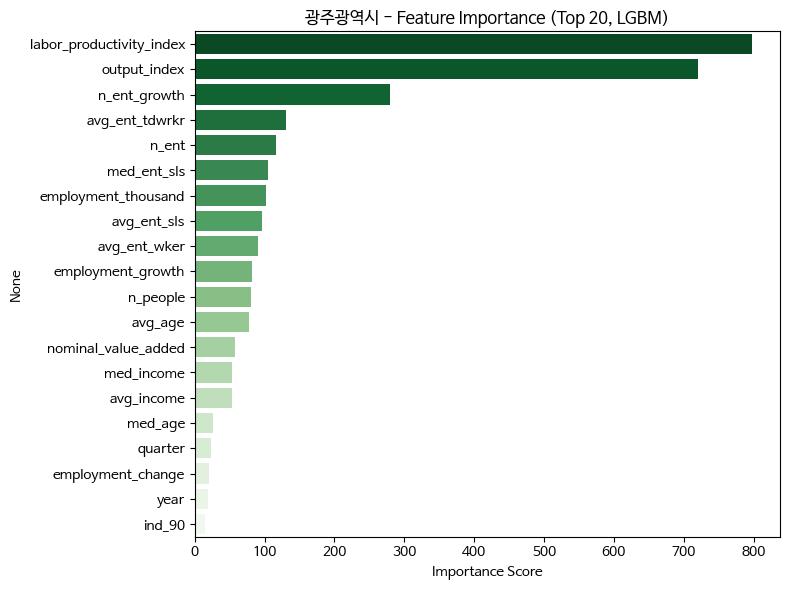


==== 지역: 대구광역시 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3807
[LightGBM] [Info] Number of data points in the train set: 1384, number of used features: 51
[LightGBM] [Info] Start training from score 0.022692


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3820
[LightGBM] [Info] Number of data points in the train set: 1384, number of used features: 54
[LightGBM] [Info] Start training from score 0.016160


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3807
[LightGBM] [Info] Number of data points in the train set: 1384, number of used features: 52
[LightGBM] [Info] Start training from score 0.012605


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3799
[LightGBM] [Info] Number of data points in the train set: 1384, number of used features: 52
[LightGBM] [Info] Start training from score 0.026760


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3805
[LightGBM] [Info] Number of data points in the train set: 1384, number of used features: 52
[LightGBM] [Info] Start training from score 0.010460


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Cross-validated R2: 0.9378 ± 0.0263
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3988
[LightGBM] [Info] Number of data points in the train set: 1730, number of used features: 91
[LightGBM] [Info] Start training from score 0.017735


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


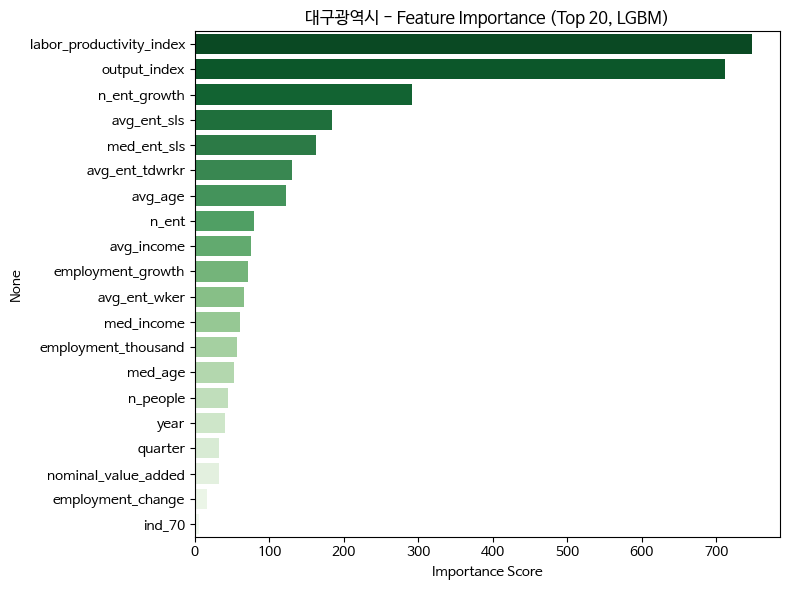


==== 지역: 대전광역시 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3823
[LightGBM] [Info] Number of data points in the train set: 1404, number of used features: 56
[LightGBM] [Info] Start training from score 0.038187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3828
[LightGBM] [Info] Number of data points in the train set: 1404, number of used features: 54
[LightGBM] [Info] Start training from score 0.010080


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3808
[LightGBM] [Info] Number of data points in the train set: 1404, number of used features: 52
[LightGBM] [Info] Start training from score 0.012881
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3790
[LightGBM] [Info] Number of data points in the train set: 1404, number of used features: 49
[LightGBM] [Info] Start training from score 0.026818


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3803
[LightGBM] [Info] Number of data points in the train set: 1404, number of used features: 53
[LightGBM] [Info] Start training from score -0.039702
✅ Cross-validated R2: 0.9123 ± 0.0488
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3998
[LightGBM] [Info] Number of data points in the train set: 1755, number of used features: 92
[LightGBM] [Info] Start training from score 0.009653


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


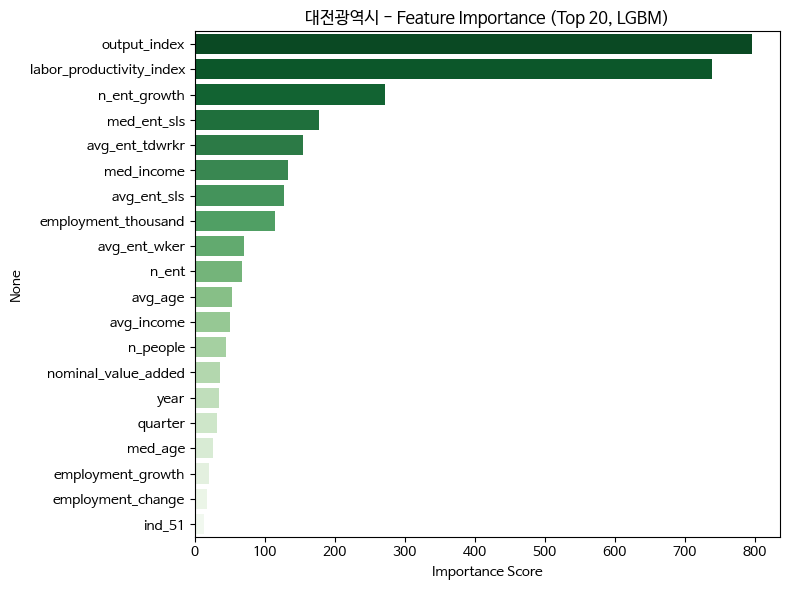


==== 지역: 부산광역시 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3819
[LightGBM] [Info] Number of data points in the train set: 1399, number of used features: 52
[LightGBM] [Info] Start training from score 0.020078
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3840
[LightGBM] [Info] Number of data points in the train set: 1399, number of used features: 57
[LightGBM] [Info] Start training from score 0.010358


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3826
[LightGBM] [Info] Number of data points in the train set: 1399, number of used features: 53
[LightGBM] [Info] Start training from score 0.006370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 1399, number of used features: 54
[LightGBM] [Info] Start training from score 0.029557


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3832
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 57
[LightGBM] [Info] Start training from score 0.012161
✅ Cross-validated R2: 0.9576 ± 0.0128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4007
[LightGBM] [Info] Number of data points in the train set: 1749, number of used features: 92
[LightGBM] [Info] Start training from score 0.015704


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


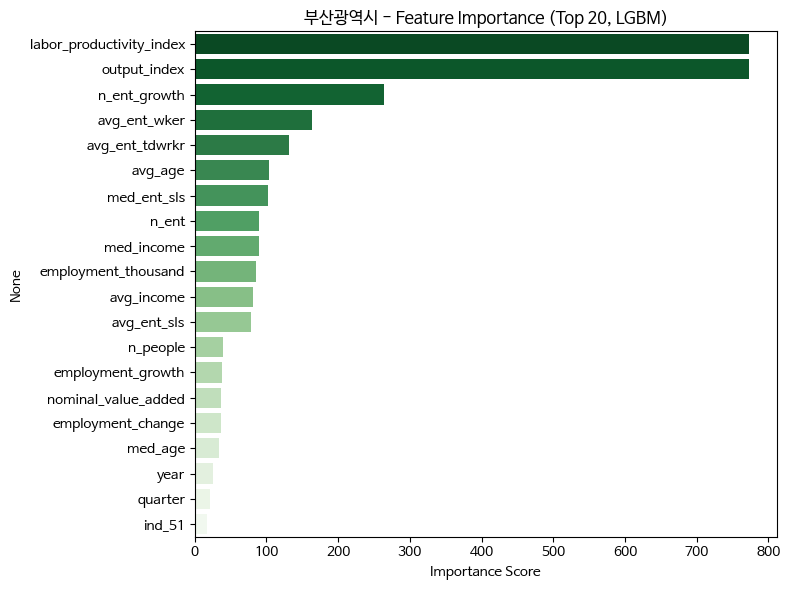


==== 지역: 서울특별시 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3806
[LightGBM] [Info] Number of data points in the train set: 1455, number of used features: 57
[LightGBM] [Info] Start training from score 0.010644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3809
[LightGBM] [Info] Number of data points in the train set: 1455, number of used features: 54
[LightGBM] [Info] Start training from score 0.006627


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 1455, number of used features: 55
[LightGBM] [Info] Start training from score -0.018536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3802
[LightGBM] [Info] Number of data points in the train set: 1455, number of used features: 53
[LightGBM] [Info] Start training from score -0.032170


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3815
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 61
[LightGBM] [Info] Start training from score -0.003544
✅ Cross-validated R2: 0.9188 ± 0.0471
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3999
[LightGBM] [Info] Number of data points in the train set: 1819, number of used features: 96
[LightGBM] [Info] Start training from score -0.007395


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


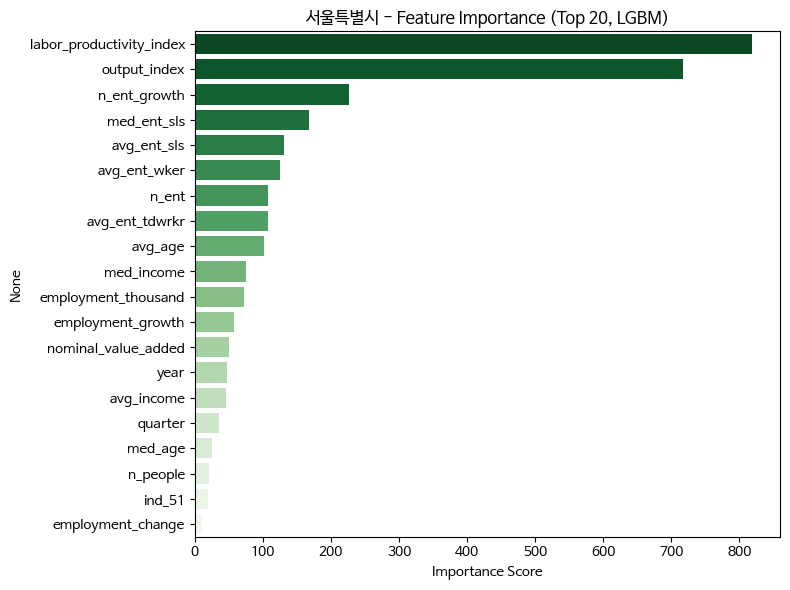


==== 지역: 세종특별자치시 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3771
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 48
[LightGBM] [Info] Start training from score -0.045496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3783
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 54
[LightGBM] [Info] Start training from score -0.047380


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3771
[LightGBM] [Info] Number of data points in the train set: 1310, number of used features: 53
[LightGBM] [Info] Start training from score -0.060978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3763
[LightGBM] [Info] Number of data points in the train set: 1310, number of used features: 48
[LightGBM] [Info] Start training from score -0.059298


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3791
[LightGBM] [Info] Number of data points in the train set: 1310, number of used features: 56
[LightGBM] [Info] Start training from score -0.078784


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Cross-validated R2: 0.9561 ± 0.0155
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3956
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 88
[LightGBM] [Info] Start training from score -0.058391


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


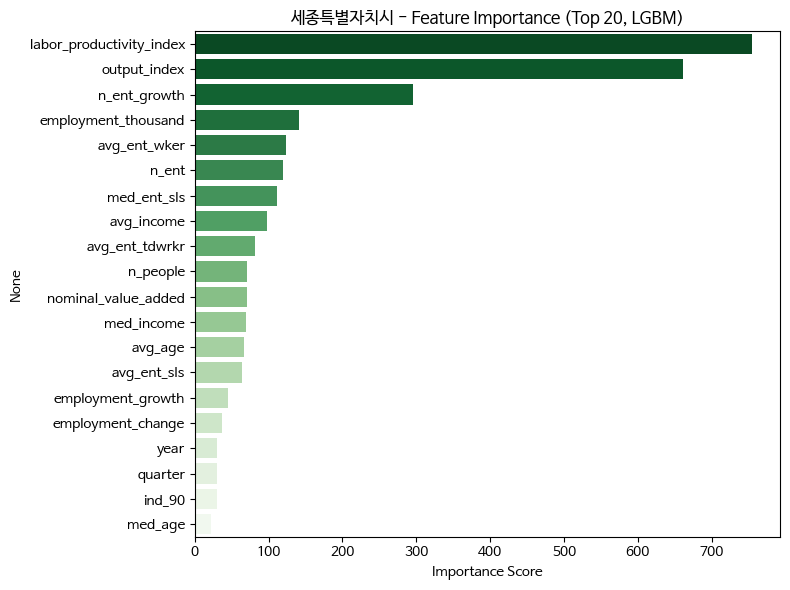


==== 지역: 울산광역시 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3799
[LightGBM] [Info] Number of data points in the train set: 1405, number of used features: 52
[LightGBM] [Info] Start training from score 0.037795


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3819
[LightGBM] [Info] Number of data points in the train set: 1405, number of used features: 50
[LightGBM] [Info] Start training from score 0.010478


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3808
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 55
[LightGBM] [Info] Start training from score -0.005166


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3805
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 52
[LightGBM] [Info] Start training from score 0.014975


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3813
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 57
[LightGBM] [Info] Start training from score 0.004293


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Cross-validated R2: 0.9411 ± 0.0349
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3996
[LightGBM] [Info] Number of data points in the train set: 1757, number of used features: 93
[LightGBM] [Info] Start training from score 0.012472


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


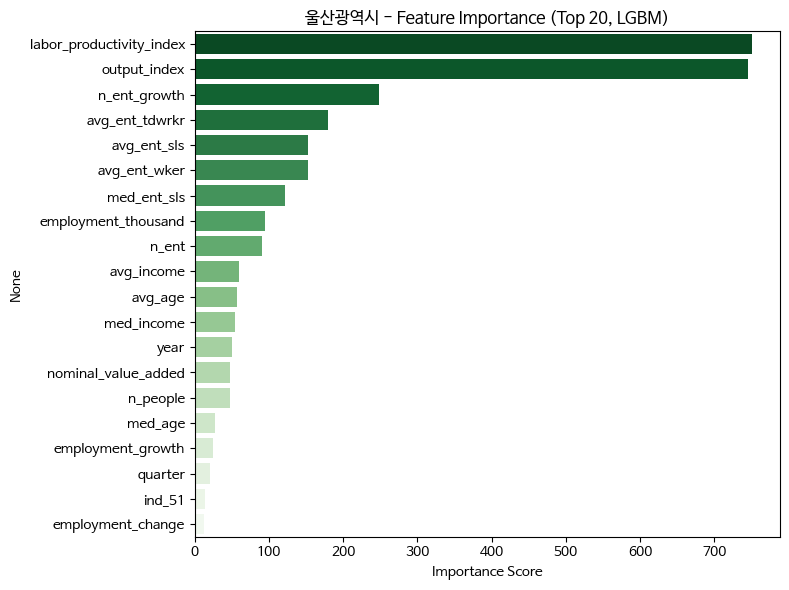


==== 지역: 인천광역시 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3833
[LightGBM] [Info] Number of data points in the train set: 1427, number of used features: 56
[LightGBM] [Info] Start training from score 0.011413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3839
[LightGBM] [Info] Number of data points in the train set: 1427, number of used features: 55
[LightGBM] [Info] Start training from score 0.016599


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3820
[LightGBM] [Info] Number of data points in the train set: 1427, number of used features: 54
[LightGBM] [Info] Start training from score 0.006073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3816
[LightGBM] [Info] Number of data points in the train set: 1427, number of used features: 51
[LightGBM] [Info] Start training from score 0.009424


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3819
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 53
[LightGBM] [Info] Start training from score 0.004587
✅ Cross-validated R2: 0.9499 ± 0.0172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4018
[LightGBM] [Info] Number of data points in the train set: 1784, number of used features: 93
[LightGBM] [Info] Start training from score 0.009619


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


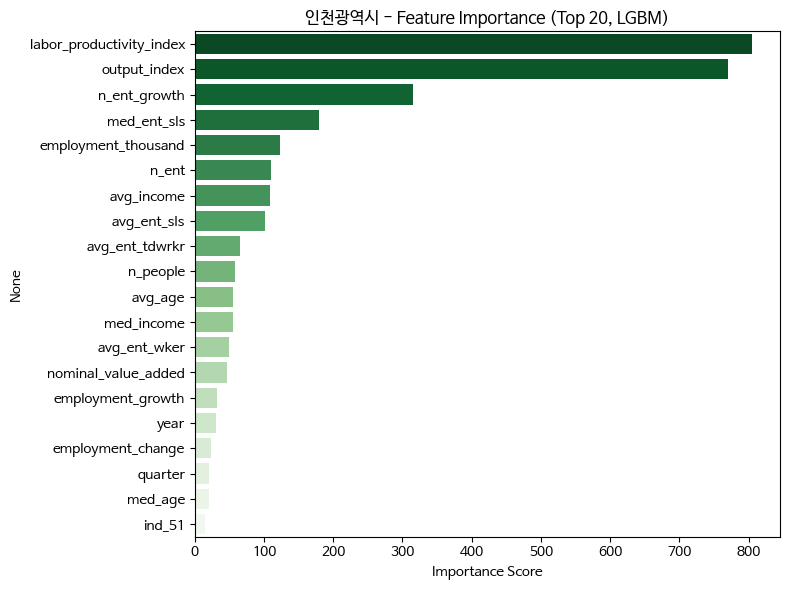


==== 지역: 전라남도 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 56
[LightGBM] [Info] Start training from score -0.048646
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3836
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 49
[LightGBM] [Info] Start training from score -0.053935


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3840
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 56
[LightGBM] [Info] Start training from score -0.081745
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3826
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 48
[LightGBM] [Info] Start training from score -0.055495


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3860
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 57
[LightGBM] [Info] Start training from score -0.069592
✅ Cross-validated R2: 0.9718 ± 0.0158
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4034
[LightGBM] [Info] Number of data points in the train set: 1785, number of used features: 93
[LightGBM] [Info] Start training from score -0.061882


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


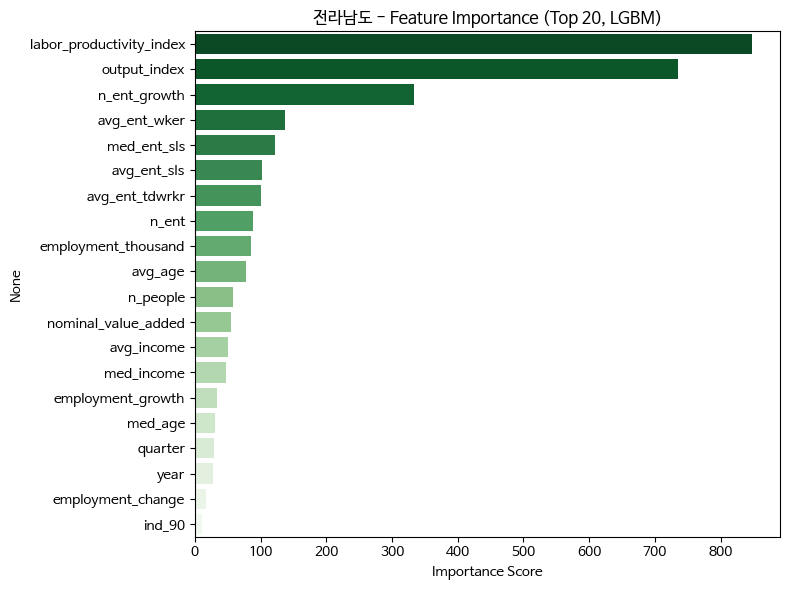


==== 지역: 전라북도 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3841
[LightGBM] [Info] Number of data points in the train set: 1422, number of used features: 51
[LightGBM] [Info] Start training from score -0.007384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3851
[LightGBM] [Info] Number of data points in the train set: 1422, number of used features: 53
[LightGBM] [Info] Start training from score 0.039168


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3835
[LightGBM] [Info] Number of data points in the train set: 1422, number of used features: 55
[LightGBM] [Info] Start training from score 0.007624
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3827
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 49
[LightGBM] [Info] Start training from score 0.020273


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3856
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 57
[LightGBM] [Info] Start training from score 0.007984
✅ Cross-validated R2: 0.9475 ± 0.0214
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4045
[LightGBM] [Info] Number of data points in the train set: 1778, number of used features: 94
[LightGBM] [Info] Start training from score 0.013533


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


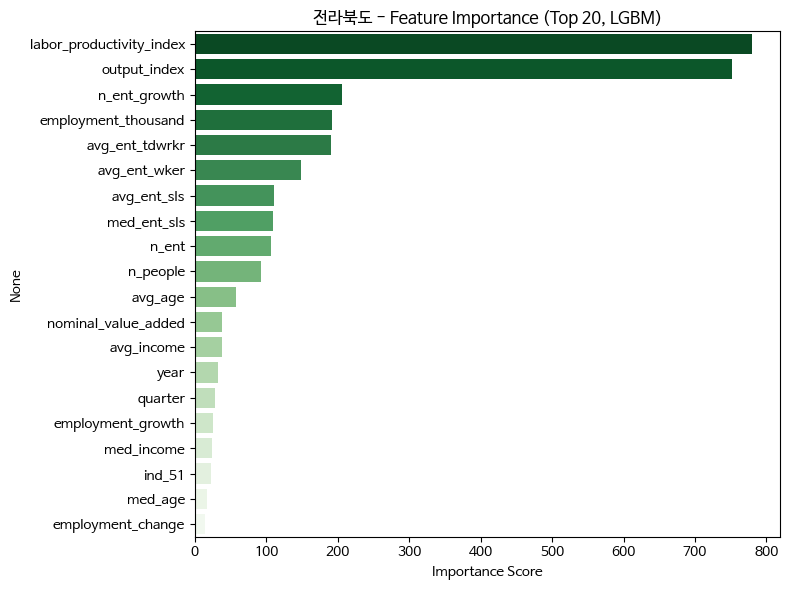


==== 지역: 제주특별자치도 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 1377, number of used features: 53
[LightGBM] [Info] Start training from score 0.059317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3833
[LightGBM] [Info] Number of data points in the train set: 1377, number of used features: 58
[LightGBM] [Info] Start training from score 0.069639


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3819
[LightGBM] [Info] Number of data points in the train set: 1378, number of used features: 54
[LightGBM] [Info] Start training from score 0.020831
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3807
[LightGBM] [Info] Number of data points in the train set: 1378, number of used features: 52
[LightGBM] [Info] Start training from score 0.026385


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3822
[LightGBM] [Info] Number of data points in the train set: 1378, number of used features: 56
[LightGBM] [Info] Start training from score -0.003051
✅ Cross-validated R2: 0.9579 ± 0.0138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4021
[LightGBM] [Info] Number of data points in the train set: 1722, number of used features: 91
[LightGBM] [Info] Start training from score 0.034616


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


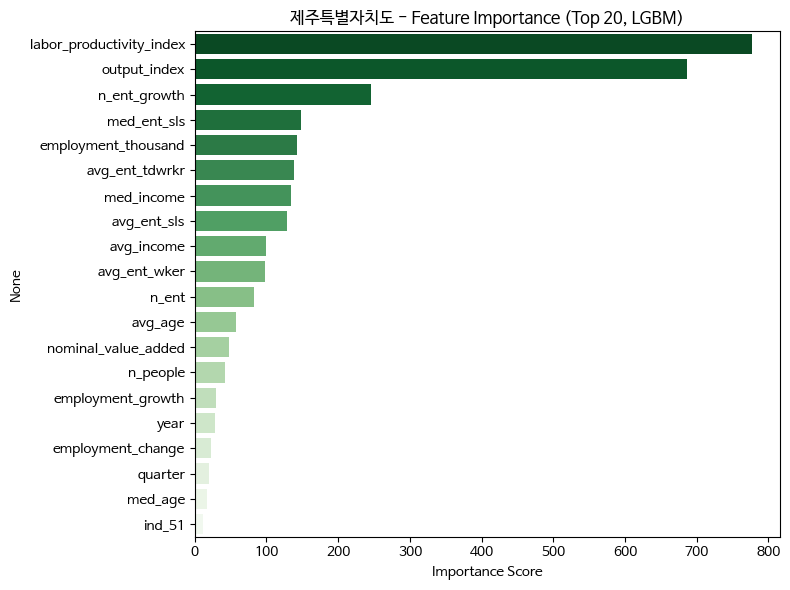


==== 지역: 충청남도 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3817
[LightGBM] [Info] Number of data points in the train set: 1419, number of used features: 53
[LightGBM] [Info] Start training from score 0.017037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3813
[LightGBM] [Info] Number of data points in the train set: 1419, number of used features: 54
[LightGBM] [Info] Start training from score 0.022701


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3832
[LightGBM] [Info] Number of data points in the train set: 1419, number of used features: 55
[LightGBM] [Info] Start training from score -0.000324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3803
[LightGBM] [Info] Number of data points in the train set: 1419, number of used features: 50
[LightGBM] [Info] Start training from score 0.027127


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3814
[LightGBM] [Info] Number of data points in the train set: 1420, number of used features: 52
[LightGBM] [Info] Start training from score -0.012020
✅ Cross-validated R2: 0.9302 ± 0.0341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4015
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 93
[LightGBM] [Info] Start training from score 0.010901


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


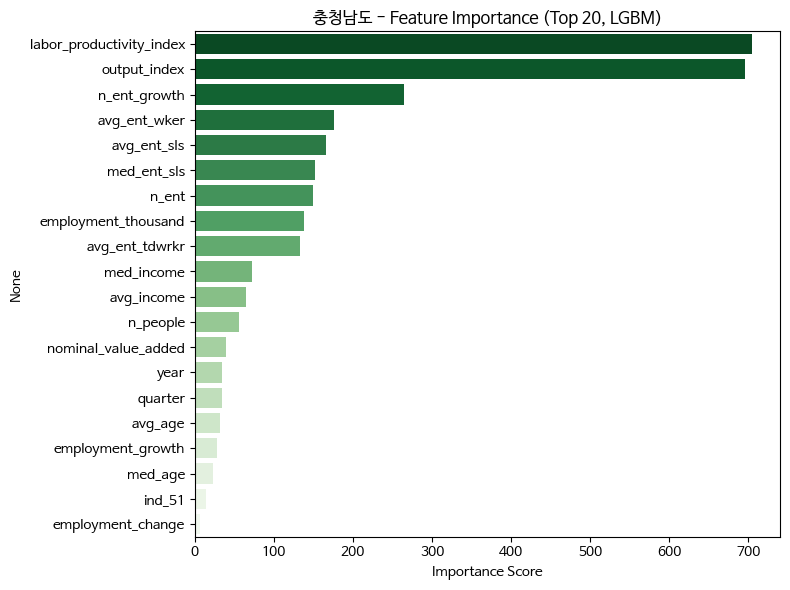


==== 지역: 충청북도 ====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3819
[LightGBM] [Info] Number of data points in the train set: 1399, number of used features: 55
[LightGBM] [Info] Start training from score 0.042517
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3827
[LightGBM] [Info] Number of data points in the train set: 1399, number of used features: 53
[LightGBM] [Info] Start training from score 0.020534


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 1399, number of used features: 51
[LightGBM] [Info] Start training from score -0.002852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3813
[LightGBM] [Info] Number of data points in the train set: 1399, number of used features: 53
[LightGBM] [Info] Start training from score 0.009756


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3829
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 55
[LightGBM] [Info] Start training from score 0.011828
✅ Cross-validated R2: 0.9555 ± 0.0129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4007
[LightGBM] [Info] Number of data points in the train set: 1749, number of used features: 92
[LightGBM] [Info] Start training from score 0.016356


/tmp/ipython-input-13-4065081204.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')


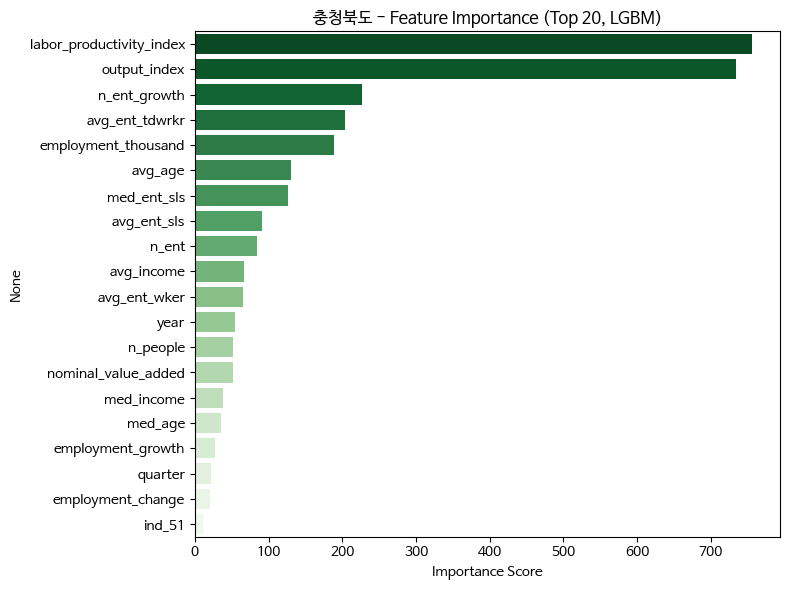

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error,make_scorer

features_base = ['n_ent', 'avg_ent_wker',
       'avg_ent_sls', 'med_ent_sls', 'avg_ent_tdwrkr',
       'n_people', 'avg_age', 'med_age', 'avg_income',
       'med_income', 'output_index', 'labor_productivity_index',
       'nominal_value_added', 'employment_thousand', 'n_ent_growth',
       'employment_growth', 'is_new_industry',
       'is_disappeared_industry', 'employment_change',
       'is_new_employment_generated', 'employment_disappeared',
       'year','quarter']


region_model_results = {}
regions = final['sido'].unique()

for region in regions:
    print(f"\n==== 지역: {region} ====")
    region_df = final[final['sido'] == region].copy()

    # 산업코드 one-hot encoding
    region_df = pd.get_dummies(region_df, columns=['industry_code'], prefix='ind')
    industry_cols = [col for col in region_df.columns if col.startswith('ind_')]
    features = features_base + industry_cols

    # 결측치 처리
    region_df = region_df.dropna(subset=features + ['composite_decline_index'])

    if region_df.empty or region_df['composite_decline_index'].nunique() < 2:
        print("🚫 데이터 부족 혹은 라벨 분산 부족 → 건너뜀")
        continue

    X = region_df[features]
    y = region_df['composite_decline_index']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = LGBMRegressor(random_state=42, n_estimators=100)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_scaled, y, scoring=make_scorer(r2_score), cv=cv)

    print(f"✅ Cross-validated R2: {scores.mean():.4f} ± {scores.std():.4f}")

    model.fit(X_scaled, y)

    # Feature importance
    importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=importance.values[:20], y=importance.index[:20], palette='Greens_r')
    plt.title(f'{region} - Feature Importance (Top 20, LGBM)')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    region_model_results[region] = {
        'model': model,
        'accuracy': scores.mean(),
        'importance': importance
    }


In [ ]:
# 전체 지역 결과
for region, result in region_model_results.items():
    print(f"\n📍 {region} - 상위 Feature 중요도")
    print(result['importance'].head(10).to_string())


📍 강원도 - 상위 Feature 중요도
output_index                733
labor_productivity_index    733
n_ent_growth                253
avg_ent_tdwrkr              164
employment_thousand         153
med_ent_sls                 150
avg_ent_sls                 140
avg_ent_wker                112
n_ent                       104
avg_income                   88

📍 경기도 - 상위 Feature 중요도
output_index                791
labor_productivity_index    707
n_ent_growth                209
avg_income                  162
n_ent                       158
med_ent_sls                 145
employment_thousand         110
avg_age                      86
avg_ent_tdwrkr               85
avg_ent_sls                  83

📍 경상남도 - 상위 Feature 중요도
output_index                714
labor_productivity_index    692
n_ent_growth                269
avg_income                  166
med_ent_sls                 144
employment_thousand         126
avg_ent_wker                120
med_income                  117
n_ent                       112

In [ ]:
# 지역별 feature 중요도 df
importance_df = pd.DataFrame({
    region: result['importance'] for region, result in region_model_results.items()
}).T


# 각 feature별 평균 중요도 계산 (지역별 가중평균도 가능)
average_importance = importance_df.mean(axis=0).sort_values(ascending=False)

print("📌 전체 지역 평균 Feature 중요도 상위 10개:")
print(average_importance.head(10))

📌 전체 지역 평균 Feature 중요도 상위 10개:
labor_productivity_index    761.294118
output_index                732.235294
n_ent_growth                262.117647
med_ent_sls                 136.823529
avg_ent_tdwrkr              127.705882
employment_thousand         119.411765
avg_ent_sls                 114.294118
avg_ent_wker                110.882353
n_ent                       106.705882
avg_income                   81.176471
dtype: float64


# 4. feature importance기반 지수 생성

In [ ]:
# # quarter 중요도 제외
# exclude_features = ['quarter_sin', 'quarter_cos']
# include_features = [col for col in importance_df.columns if col not in exclude_features]

# feature importance 정규화 (sum(w_i)=1)
region_weights = importance_df.div(importance_df.sum(axis=1), axis=0)

In [ ]:
final_encoded = pd.get_dummies(final, columns=['industry_code'], prefix='ind')

# One-Hot 컬럼 float 타입 변환
ind_cols = [col for col in final_encoded.columns if col.startswith('ind_')]
final_encoded[ind_cols] = final_encoded[ind_cols].astype(float)

In [ ]:
only_in_region_weights = set(region_weights.columns) - set(final_encoded.columns)
only_in_final_encoded = set(final_encoded.columns) - set(region_weights.columns)

print("region_weights에만 있는 컬럼들:", only_in_region_weights)
print("final_encoded에만 있는 컬럼들:", only_in_final_encoded)

region_weights에만 있는 컬럼들: set()
final_encoded에만 있는 컬럼들: {'med_ent_wker', 'composite_decline_index', 'base_year_x', 'med_ent_tdwrkr', 'sido'}


In [ ]:
final_encoded = final_encoded.drop(['composite_decline_index', 'med_ent_tdwrkr', 'base_year_x', 'med_ent_wker'], axis=1 )


for region in region_weights.index:
    region_mask = final_encoded['sido'] == region
    if region_mask.sum() == 0:
        continue

    region_data = final_encoded.loc[region_mask, region_weights.columns]

    # 스케일링
    scaler = StandardScaler()
    region_data_scaled = pd.DataFrame(
        scaler.fit_transform(region_data),
        columns=region_data.columns,
        index=region_data.index
    )

    # 가중치: NaN을 0으로 대체
    weights = region_weights.loc[region].fillna(0)

    # 가중합 계산
    weighted_index = region_data_scaled.dot(weights.values)

    final_encoded.loc[region_mask, 'weighted_decline_index'] = weighted_index

In [ ]:
# One-hot 된 컬럼만 추출
ind_cols = [col for col in final_encoded.columns if col.startswith('ind_')]

# 각 행마다 값이 1인 컬럼명을 추출하고 숫자만 추출하여 industry_code로 변환
final_encoded['industry_code'] = final_encoded[ind_cols].idxmax(axis=1).str.replace('ind_', '').astype(int)

final['weighted_decline_index'] = final_encoded['weighted_decline_index']

# 5. 타당성 및 결과 확인

In [ ]:
from scipy.stats import spearmanr, pearsonr

# 상관계수 계산
pearson_corr, _ = pearsonr(final['weighted_decline_index'], final['composite_decline_index'])
spearman_corr, _ = spearmanr(final['weighted_decline_index'], final['composite_decline_index'])

print(f"📊 Pearson 상관계수: {pearson_corr:.4f}")
print(f"📊 Spearman 상관계수 (순위 기반): {spearman_corr:.4f}")

📊 Pearson 상관계수: 0.9334
📊 Spearman 상관계수 (순위 기반): 0.8873


/tmp/ipython-input-27-291448914.py:22: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


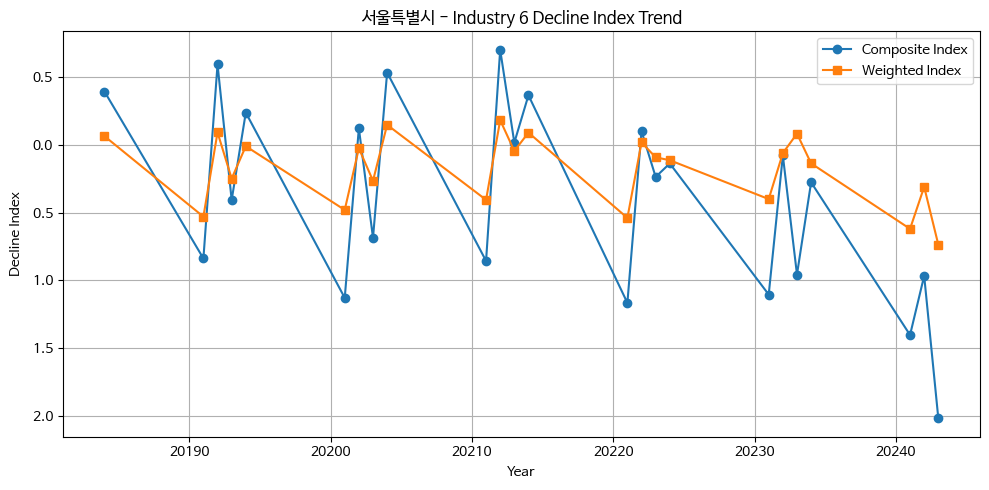

In [ ]:
import matplotlib.pyplot as plt

# 입력
target_region = '서울특별시'
target_industry = 6

subset = final[(final['sido'] == target_region) & (final['industry_code'] == target_industry)].copy()
subset = subset.sort_values('base_year_x')

plt.figure(figsize=(10, 5))
plt.plot(subset['base_year_x'], subset['composite_decline_index'], marker='o', label='Composite Index')
plt.plot(subset['base_year_x'], subset['weighted_decline_index'], marker='s', label='Weighted Index')
plt.title(f"{target_region} - Industry {target_industry} Decline Index Trend")
plt.xlabel("Year")
plt.ylabel("Decline Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


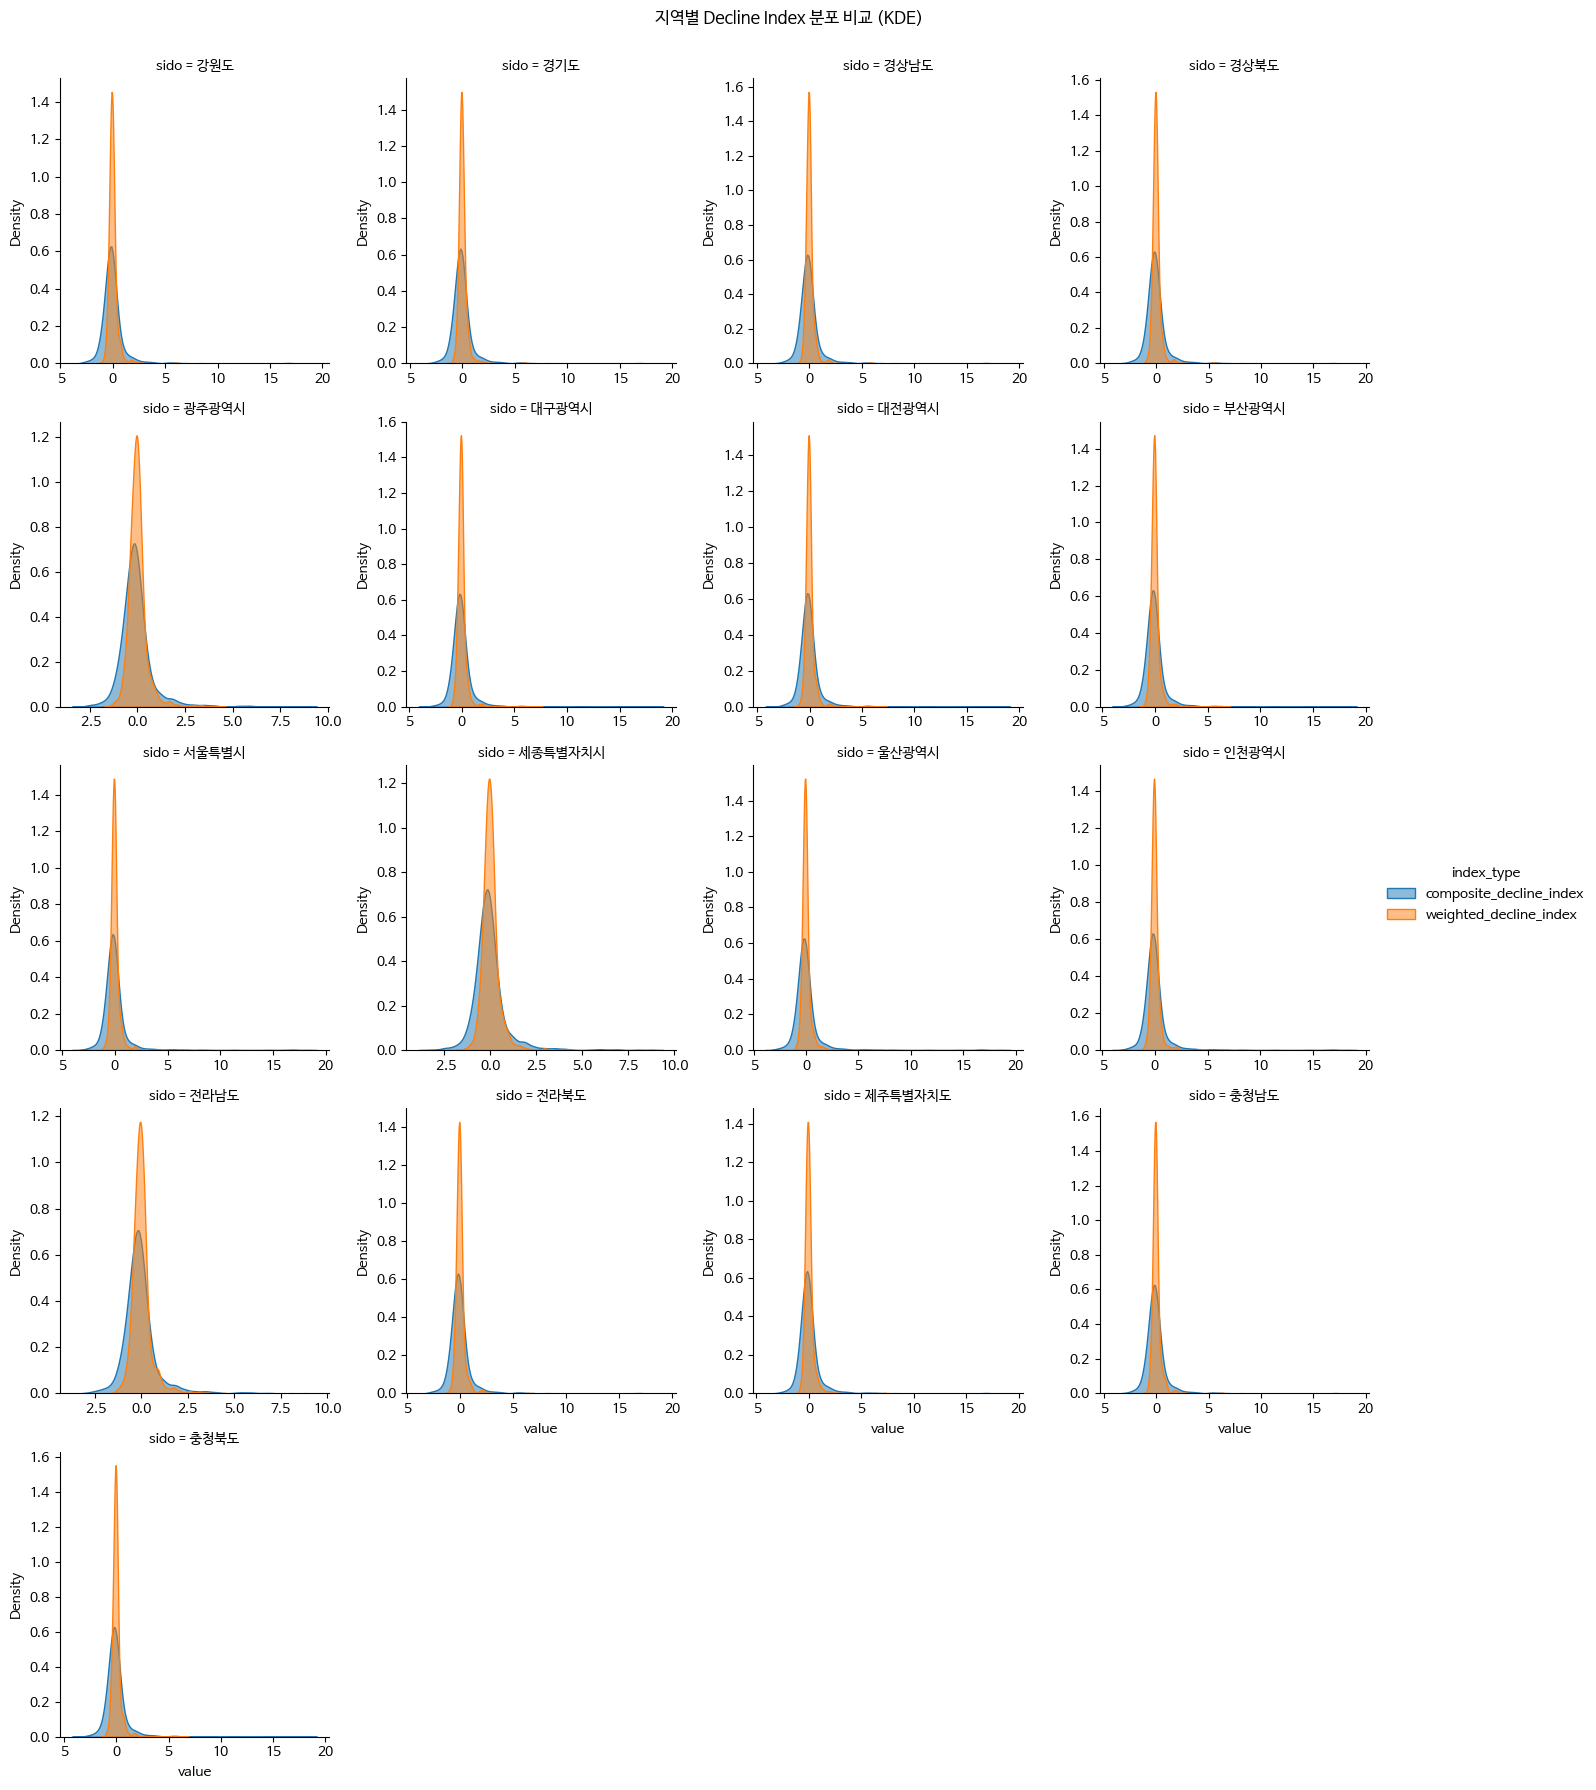

In [ ]:
melted = final[['sido', 'composite_decline_index', 'weighted_decline_index']].melt(id_vars='sido',
    value_vars=['composite_decline_index', 'weighted_decline_index'],
    var_name='index_type', value_name='value')

g = sns.FacetGrid(melted, col='sido', hue='index_type', col_wrap=4, height=3.5, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', fill=True, alpha=0.5)
g.add_legend()
g.fig.suptitle("지역별 Decline Index 분포 비교 (KDE)", y=1.02)
plt.show()


#6. 지수 비교(DII)

In [ ]:
final_사양판단본 = pd.read_csv('/content/drive/MyDrive/DScover/메인프로젝트/메인프로젝트/Main/final_ final3.csv')
df10_3 = pd.read_csv('/content/drive/MyDrive/DScover/메인프로젝트/메인프로젝트/Main/final_ final3.csv')
df10_2 = pd.read_csv('/content/drive/MyDrive/DScover/메인프로젝트/메인프로젝트/Main/ver/final_10_2.csv')
df15_2 = pd.read_csv('/content/drive/MyDrive/DScover/메인프로젝트/메인프로젝트/Main/ver/final_15_2.csv')
df15_3 = pd.read_csv('/content/drive/MyDrive/DScover/메인프로젝트/메인프로젝트/Main/ver/final_15_3.csv')
df20_2 = pd.read_csv('/content/drive/MyDrive/DScover/메인프로젝트/메인프로젝트/Main/ver/final_20_2.csv')
df20_3 = pd.read_csv('/content/drive/MyDrive/DScover/메인프로젝트/메인프로젝트/Main/ver/final_20_3.csv')

In [ ]:
# 공통 기준 컬럼 예시 (필요에 따라 조정)
key_cols = ['sido', 'industry_code', 'base_year_x']

merged_df = pd.merge(
    final_사양판단본[key_cols + ['DII']],
    final[key_cols + ['weighted_decline_index']],
    on=key_cols,
    how='inner'  # 또는 'outer', 비교 목적에 맞게 선택
)

In [ ]:
corr = merged_df[['DII', 'weighted_decline_index']].corr().iloc[0,1]
print(f"상관계수 (DII vs weighted_decline_index): {corr:.4f}")

merged_df['DII_rank'] = merged_df['DII'].rank()
merged_df['weighted_rank'] = merged_df['weighted_decline_index'].rank()

spearman_corr = merged_df[['DII_rank', 'weighted_rank']].corr(method='spearman').iloc[0,1]
print(f"순위 기반 스피어만 상관계수: {spearman_corr:.4f}")



# 그룹별 변화량(diff)
merged_df['DII_diff'] = merged_df.groupby(['sido', 'industry_code'])['DII'].diff()
merged_df['weighted_diff'] = merged_df.groupby(['sido', 'industry_code'])['weighted_decline_index'].diff()

# 변화량 상관계수
diff_corr = merged_df[['DII_diff', 'weighted_diff']].corr().iloc[0,1]
print(f"변화량(diff) 상관계수: {diff_corr:.4f}")

상관계수 (DII vs weighted_decline_index): 0.7021
순위 기반 스피어만 상관계수: 0.7527
변화량(diff) 상관계수: 0.4194


## 6-1. 시각화

/tmp/ipython-input-100-2741431667.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


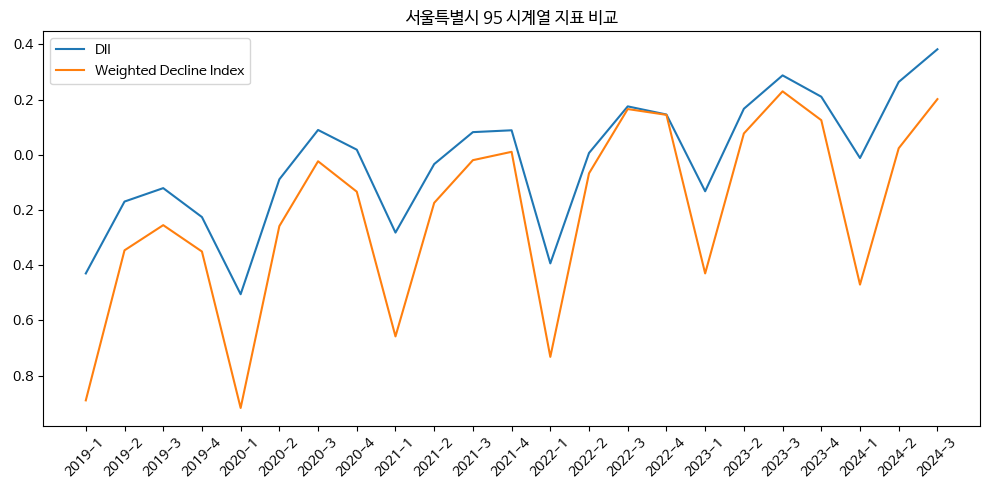

(25, 51)

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import zscore

key_cols = ['sido', 'industry_code', 'year', 'quarter']
merged_df = pd.merge(
    final_사양판단본[key_cols + ['DII']],
    final[key_cols + ['weighted_decline_index']],
    on=key_cols,
    how='inner'
)
merged_df['DII_z'] = zscore(merged_df['DII'])
merged_df['WeightedIndex_z'] = zscore(merged_df['weighted_decline_index'])

# 예: 특정 지역, 산업 선택
region = '서울특별시'
industry = 95 # 예시 코드

df_sel = merged_df[(merged_df['sido'] == region) & (merged_df['industry_code'] == industry)]

plt.figure(figsize=(10,5))
plt.plot(df_sel['year'].astype(str) + '-' + df_sel['quarter'].astype(str), df_sel['DII_z'], label='DII')
plt.plot(df_sel['year'].astype(str) + '-' + df_sel['quarter'].astype(str), df_sel['WeightedIndex_z'], label='Weighted Decline Index')
plt.xticks(rotation=45)
plt.title(f"{region} {industry} 시계열 지표 비교")
plt.legend()
plt.tight_layout()
plt.show()
25, 51

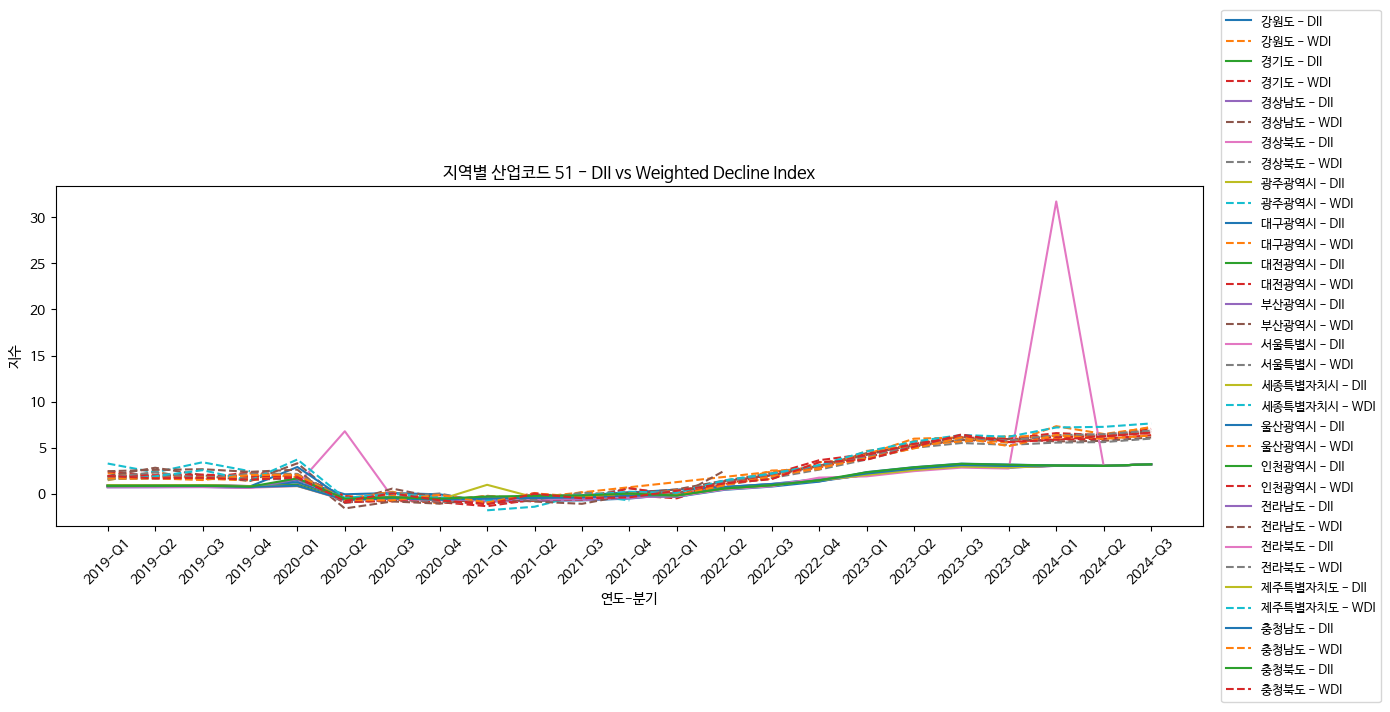

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# year_quarter 생성
final['year_quarter'] = final['year'].astype(str) + '-Q' + final['quarter'].astype(str)
final_사양판단본['year_quarter'] = final_사양판단본['year'].astype(str) + '-Q' + final_사양판단본['quarter'].astype(str)

# 병합
merged = pd.merge(
    final[['sido', 'industry_code', 'year_quarter', 'weighted_decline_index']],
    final_사양판단본[['sido', 'industry_code', 'year_quarter', 'DII']],
    on=['sido', 'industry_code', 'year_quarter'],
    how='inner'
)

# 산업코드 51 필터링
df_51 = merged[merged['industry_code'] == 51].copy()
df_51 = df_51.sort_values(by=['sido', 'year_quarter'])

# 그래프 그리기
plt.figure(figsize=(14, 6))

for region in df_51['sido'].unique():
    region_df = df_51[df_51['sido'] == region]
    plt.plot(region_df['year_quarter'], region_df['DII'], label=f'{region} - DII', linestyle='-')
    plt.plot(region_df['year_quarter'], region_df['weighted_decline_index'], label=f'{region} - WDI', linestyle='--')

plt.title('지역별 산업코드 51 - DII vs Weighted Decline Index')
plt.xlabel('연도-분기')
plt.ylabel('지수')
plt.xticks(rotation=45)

# 범례를 그래프 바깥 오른쪽에 배치
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=9)
plt.tight_layout()
plt.show()


/tmp/ipython-input-88-1377844596.py:11: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


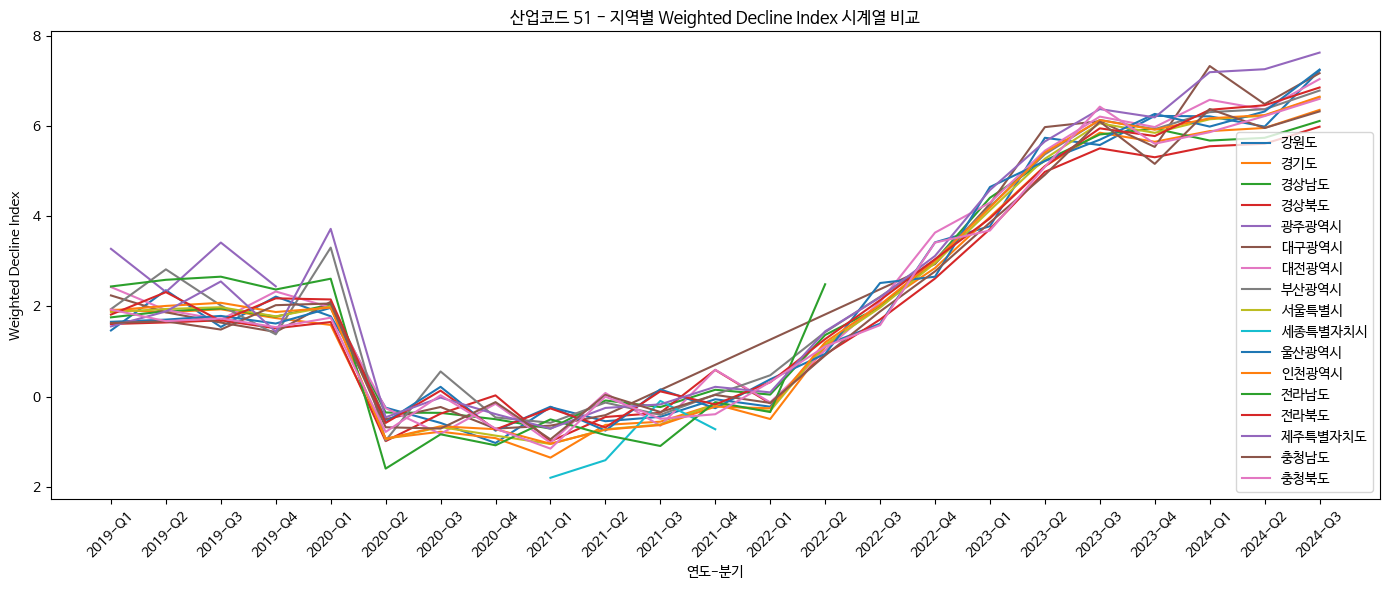

In [ ]:
plt.figure(figsize=(14, 6))
for region in df_51['sido'].unique():
    temp = df_51[df_51['sido'] == region]
    plt.plot(temp['year_quarter'], temp['weighted_decline_index'], label=region)

plt.title('산업코드 51 - 지역별 Weighted Decline Index 시계열 비교')
plt.xlabel('연도-분기')
plt.ylabel('Weighted Decline Index')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


/tmp/ipython-input-78-3623763846.py:35: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


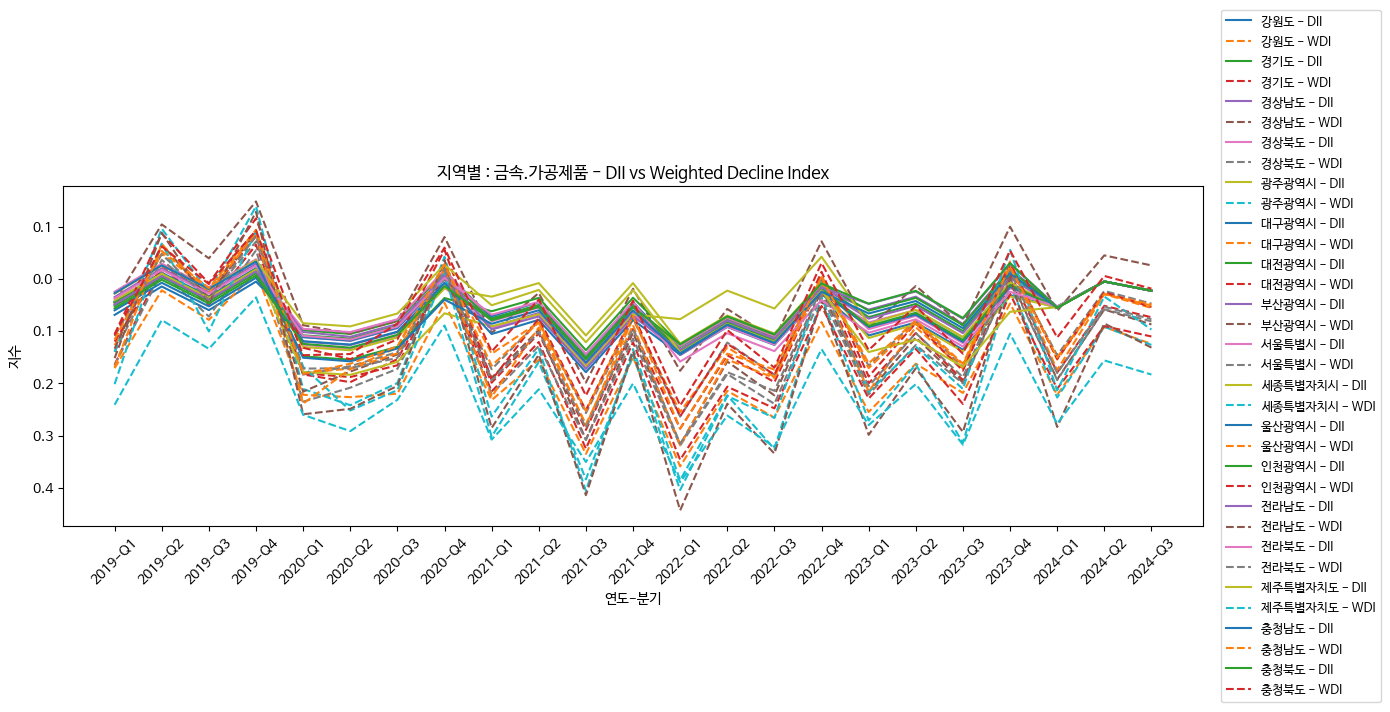

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# year_quarter 생성
final['year_quarter'] = final['year'].astype(str) + '-Q' + final['quarter'].astype(str)
final_사양판단본['year_quarter'] = final_사양판단본['year'].astype(str) + '-Q' + final_사양판단본['quarter'].astype(str)

# 병합
merged = pd.merge(
    final[['sido', 'industry_code', 'year_quarter', 'weighted_decline_index']],
    final_사양판단본[['sido', 'industry_code', 'year_quarter', 'DII']],
    on=['sido', 'industry_code', 'year_quarter'],
    how='inner'
)

# 산업코드 51 필터링
df_25 = merged[merged['industry_code'] == 25].copy()
df_25= df_25.sort_values(by=['sido', 'year_quarter'])

# 그래프 그리기
plt.figure(figsize=(14, 6))

for region in df_25['sido'].unique():
    region_df = df_25[df_25['sido'] == region]
    plt.plot(region_df['year_quarter'], region_df['DII'], label=f'{region} - DII', linestyle='-')
    plt.plot(region_df['year_quarter'], region_df['weighted_decline_index'], label=f'{region} - WDI', linestyle='--')

plt.title('지역별 : 금속.가공제품 - DII vs Weighted Decline Index')
plt.xlabel('연도-분기')
plt.ylabel('지수')
plt.xticks(rotation=45)

# 범례를 그래프 바깥 오른쪽에 배치
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=9)
plt.tight_layout()
plt.show()

/tmp/ipython-input-80-2951324652.py:11: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()


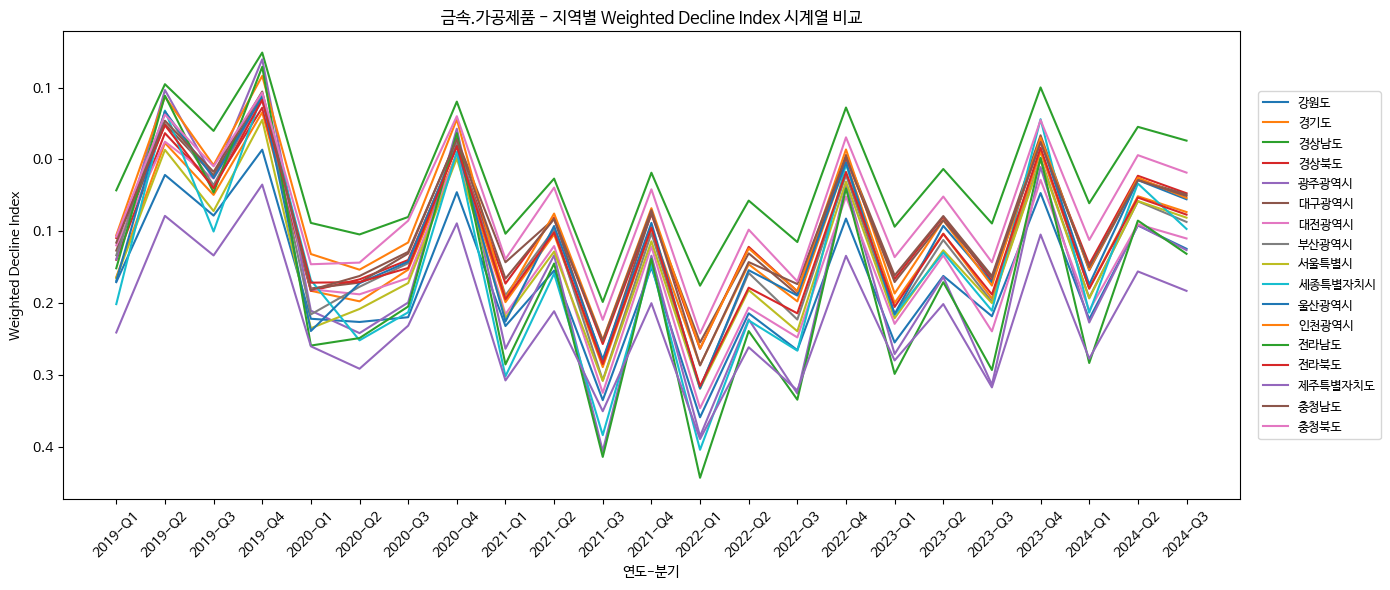

In [ ]:
plt.figure(figsize=(14, 6))
for region in df_25['sido'].unique():
    temp = df_25[df_25['sido'] == region]
    plt.plot(temp['year_quarter'], temp['weighted_decline_index'], label=region)

plt.title('금속.가공제품 - 지역별 Weighted Decline Index 시계열 비교')
plt.xlabel('연도-분기')
plt.ylabel('Weighted Decline Index')
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=9)
plt.tight_layout()
plt.show()


/tmp/ipython-input-102-1767772141.py:11: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


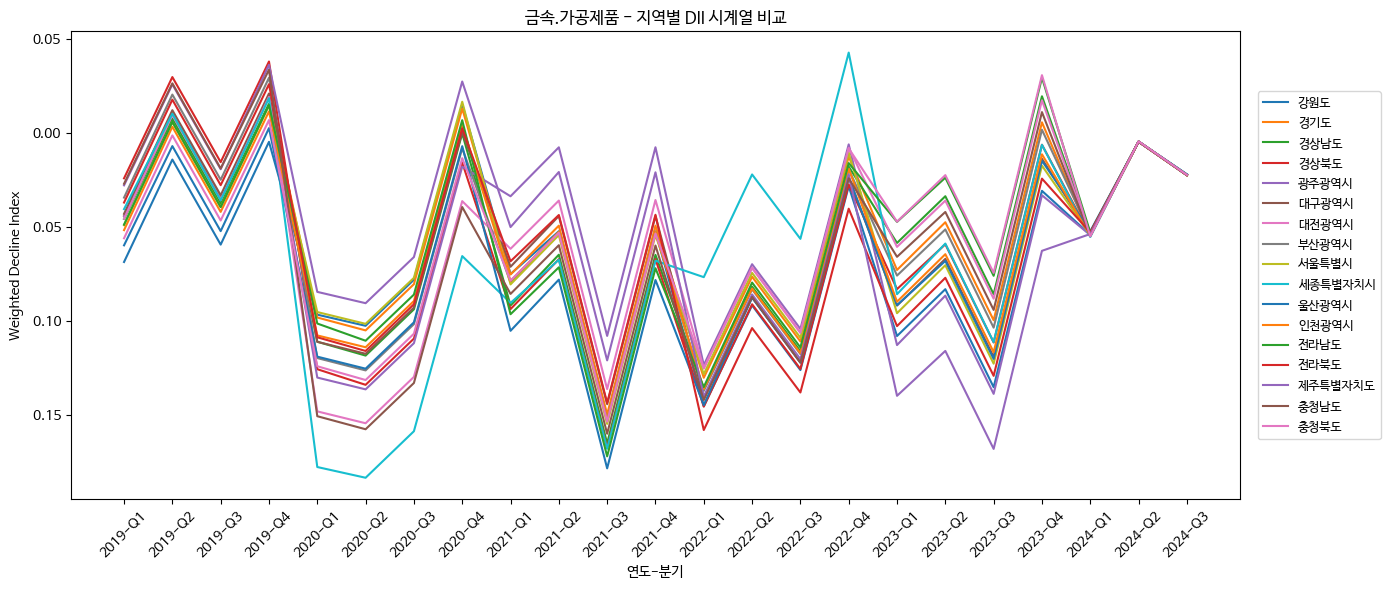

In [ ]:
plt.figure(figsize=(14, 6))
for region in df_25['sido'].unique():
    temp = df_25[df_25['sido'] == region]
    plt.plot(temp['year_quarter'], temp['DII'], label=region)

plt.title('금속.가공제품 - 지역별 DII 시계열 비교')
plt.xlabel('연도-분기')
plt.ylabel('Weighted Decline Index')
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
# 산업 단위 평균 지수 계산
industry_decline = merged_df.groupby(['sido', 'industry_code'])['DII'].mean().reset_index()

# 내림차순 정렬: 지수가 클수록 쇠퇴 산업 후보
top_declining = industry_decline.sort_values('DII', ascending=False)

# 상위 10개 산업 (가장 쇠퇴 지수가 높은)
print("🔻 상위 10개 사양산업 후보")
print(top_declining.head(10))

# 하위 10개 산업 (가장 활발한 산업)
print("🔺 하위 10개 산업")
print(top_declining.tail(10))


🔻 상위 10개 사양산업 후보
         sido  industry_code       DII
1017     전라북도             51  2.189493
737   세종특별자치시             84  1.624865
270      경상북도             51  1.308948
419     대구광역시             51  1.278486
1240     충청북도             51  1.147672
790     울산광역시             51  1.118226
1090  제주특별자치도             51  1.088355
43        강원도             51  1.074139
866     인천광역시             51  1.050859
567     부산광역시             51  1.050388
🔺 하위 10개 산업
         sido  industry_code       DII
183      경상남도             35 -0.241513
1169     충청남도             58 -0.242088
794     울산광역시             58 -0.242658
1228     충청북도             35 -0.247151
258      경상북도             35 -0.251796
825     인천광역시              5 -0.275367
408     대구광역시             36 -0.303585
716   세종특별자치시             51 -0.336985
632     서울특별시             36 -0.381530
705   세종특별자치시             36 -0.879821


In [ ]:
# 산업 단위 평균 지수 계산
industry_decline = merged_df.groupby(['sido', 'industry_code'])['weighted_decline_index'].mean().reset_index()

# 내림차순 정렬: 지수가 클수록 쇠퇴 산업 후보
top_declining = industry_decline.sort_values('weighted_decline_index', ascending=False)

# 상위 10개 산업 (가장 쇠퇴 지수가 높은)
print("🔻 상위 10개 사양산업 후보")
print(top_declining.head(10))

# 하위 10개 산업 (가장 활발한 산업)
print("🔺 하위 10개 산업")
print(top_declining.tail(10))


🔻 상위 10개 사양산업 후보
         sido  industry_code  weighted_decline_index
419     대구광역시             51                2.922839
344     광주광역시             51                2.864677
1090  제주특별자치도             51                2.657447
567     부산광역시             51                2.512344
493     대전광역시             51                2.464731
1017     전라북도             51                2.399891
790     울산광역시             51                2.368348
43        강원도             51                2.301646
195      경상남도             51                2.290207
866     인천광역시             51                2.244226
🔺 하위 10개 산업
         sido  industry_code  weighted_decline_index
1244     충청북도             58               -0.422531
825     인천광역시              5               -0.424883
946      전라남도             58               -0.440620
348     광주광역시             58               -0.450007
1075  제주특별자치도             32               -0.469364
701   세종특별자치시             32               -0.501548
329     광주광역시    

In [ ]:
!pip install openpyxl

# 엑셀로 저장
final.to_excel('최종_index.xlsx', index=False)

# 다운로드
from google.colab import files
files.download('최종_index.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 사양산업 후보

In [ ]:
industry_map = pd.read_excel('/content/drive/MyDrive/DScover/메인프로젝트/메인프로젝트/Main/중분류 11차.xlsx')

# 산업코드-산업명 매핑
industry_map = dict(zip(industry_map["코드"], industry_map["항목명"]))

# 사양산업만 필터링
declining_df = df_labeled[df_labeled["is_declining"] == 1]

# 산업코드별 사양산업 분기 수 집계
industry_counts = declining_df["industry_code"].value_counts()

# 코드 → 산업명으로 매핑
industry_counts_named = industry_counts.rename(index=industry_map)

/tmp/ipython-input-37-3816043198.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_counts_named.index, y=industry_counts_named.values, palette="Blues_d")
/tmp/ipython-input-37-3816043198.py:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


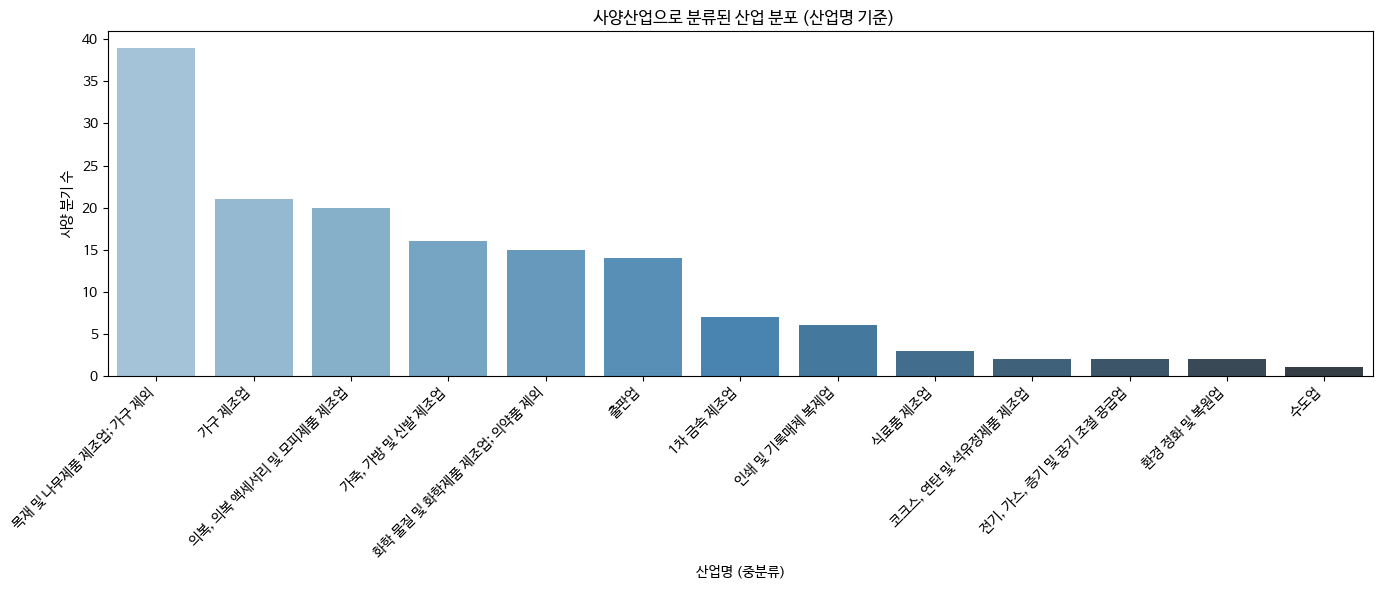

In [ ]:
# 2. 사양산업만 필터링
declining_df = df_labeled[df_labeled["is_declining"] == 1]

# 3. 산업코드별 사양산업 분기 수 집계
industry_counts = declining_df["industry_code"].value_counts().sort_values(ascending=False)

# 4. 코드 → 산업명으로 매핑 (산업명이 없으면 코드 그대로 표시)
industry_counts_named = industry_counts.rename(index=lambda x: industry_map.get(x, str(x)))

# 5. 시각화
plt.figure(figsize=(14, 6))
sns.barplot(x=industry_counts_named.index, y=industry_counts_named.values, palette="Blues_d")
plt.title("📉 사양산업으로 분류된 산업 분포 (산업명 기준)")
plt.xlabel("산업명 (중분류)")
plt.ylabel("사양 분기 수")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/tmp/ipython-input-47-3029692465.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_risk_named.index, y=high_risk_named.values, palette="Reds")
/tmp/ipython-input-47-3029692465.py:18: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


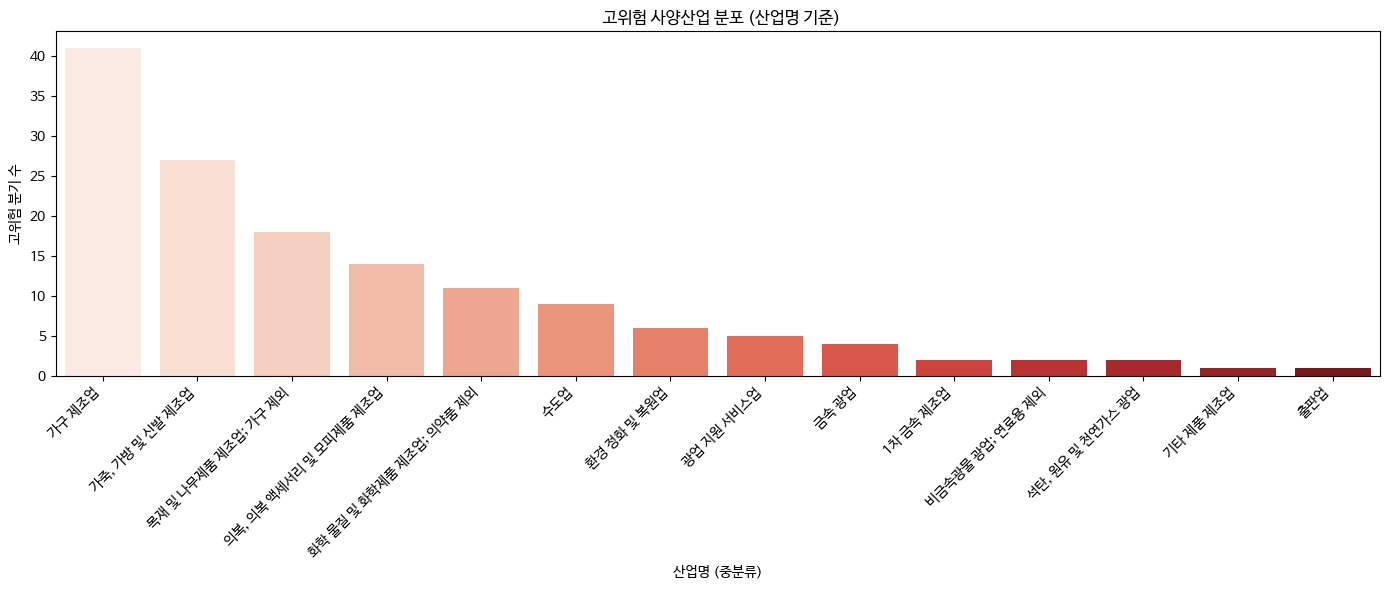

산업명(중분류)  고위험 분기 수
0                    가구 제조업        41
1           가죽, 가방 및 신발 제조업        27
2      목재 및 나무제품 제조업; 가구 제외        18
3    의복, 의복 액세서리 및 모피제품 제조업        14
4  화학 물질 및 화학제품 제조업; 의약품 제외        11

In [ ]:
# 1. 고위험 사양산업 필터링
high_risk_df = df_labeled[(df_labeled["risk_level_5"] == "High Risk") & (df_labeled["is_declining"] == 1)]

# 2. 산업코드별 고위험 분기 수 집계
high_risk_counts = high_risk_df["industry_code"].value_counts().sort_values(ascending=False)

# 3. 산업코드 → 산업명 매핑 (industry_map: 예 {76: "섬유업", 88: "자동차제조업", ...})
# 매핑이 안 된 경우에는 코드 그대로 유지
high_risk_named = high_risk_counts.rename(index=lambda x: industry_map.get(x, str(x)))

# 4. 시각화
plt.figure(figsize=(14, 6))
sns.barplot(x=high_risk_named.index, y=high_risk_named.values, palette="Reds")
plt.title("🔴 고위험 사양산업 분포 (산업명 기준)")
plt.xlabel("산업명 (중분류)")
plt.ylabel("고위험 분기 수")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 5. 상위 5개 표 형태 출력
top5_high_risk = high_risk_named.head(5).reset_index()
top5_high_risk.columns = ['산업명(중분류)', '고위험 분기 수']

from IPython.display import display
display(top5_high_risk)


/tmp/ipython-input-8-4064684341.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_candidate_counts.index, y=region_candidate_counts.values, palette='Reds')


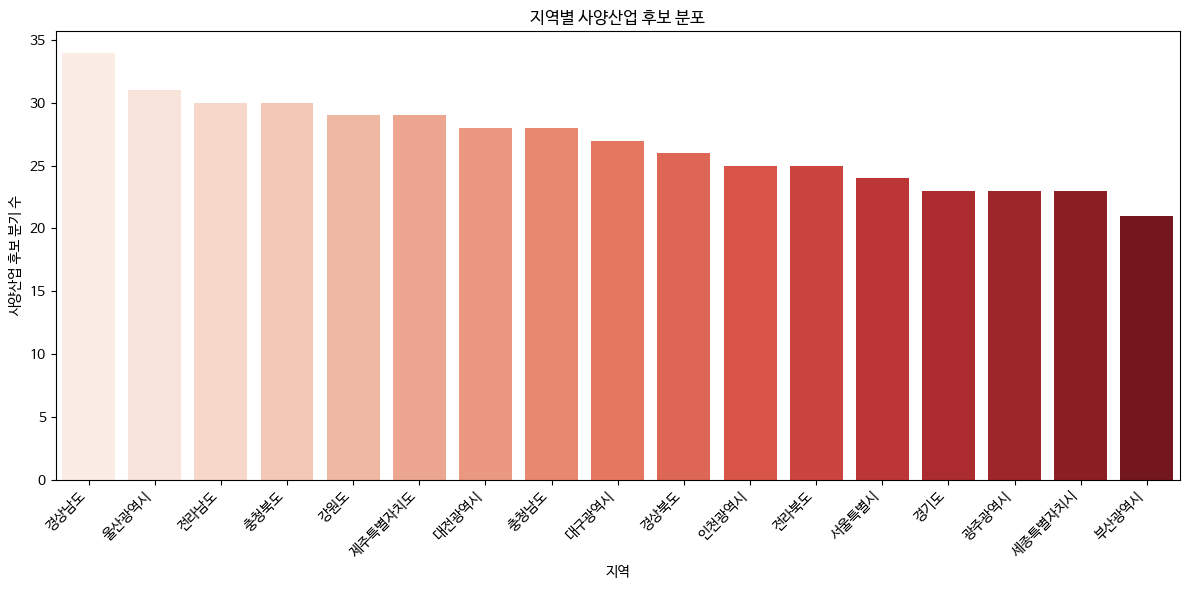

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 사양산업 후보 필터링
candidate_df = df10_2[df10_2['is_declining'] == 1]

# 지역별 후보 수 집계
region_candidate_counts = candidate_df.groupby('sido').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=region_candidate_counts.index, y=region_candidate_counts.values, palette='Reds')
plt.title('지역별 사양산업 후보 분포')
plt.xlabel('지역')
plt.ylabel('사양산업 후보 분기 수')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-49-3504209979.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_candidate_counts.index, y=region_candidate_counts.values, palette='Reds')


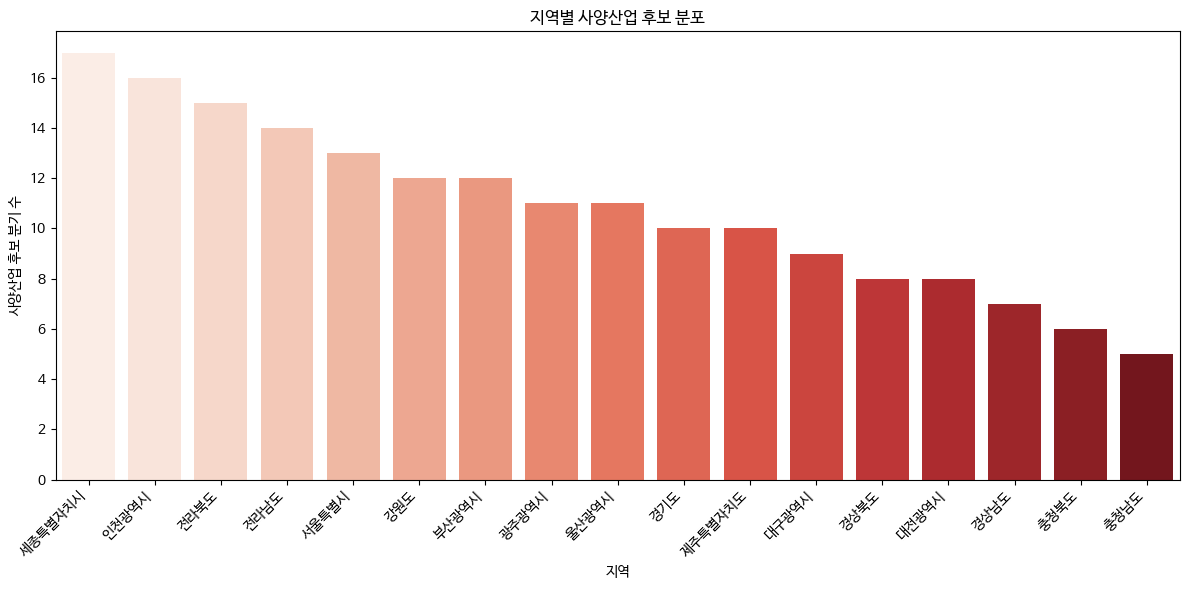

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 사양산업 후보 필터링
candidate_df = df_labeled[df_labeled['is_declining'] == True]

# 지역별 후보 수 집계
region_candidate_counts = candidate_df.groupby('sido').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=region_candidate_counts.index, y=region_candidate_counts.values, palette='Reds')
plt.title('지역별 사양산업 후보 분포')
plt.xlabel('지역')
plt.ylabel('사양산업 후보 분기 수')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 사양산업 후보 필터링
candidate_df = df_labeled[df_labeled['is_declining'] == True]

# 지역별 후보 수 집계
region_candidate_counts = candidate_df.groupby('sido').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=region_candidate_counts.index, y=region_candidate_counts.values, palette='Reds')
plt.title('지역별 사양산업 후보 분포')
plt.xlabel('지역')
plt.ylabel('사양산업 후보 분기 수')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## (추가) 사양산업기준 변경

In [ ]:
## 사양산업 판단 기준 - 연속 3분기 하락&타지역 산업지수 편차
# ✅ 연속 3분기 하락 여부
final['decline_3q'] = (
    (final['decline_level'] < final.groupby(['sido', 'industry_code'])['decline_level'].shift(1)) &
    (final['decline_level'] < final.groupby(['sido', 'industry_code'])['decline_level'].shift(2))
)

# ✅ 타 지역 대비 산업지수 편차
industry_avg = final.groupby(['industry_code', 'base_year_x'])['decline_level'].transform('mean')
industry_std = final.groupby(['industry_code', 'base_year_x'])['decline_level'].transform('std')

final['relative_gap'] = (final['decline_level'] - industry_avg) / industry_std
final['below_threshold'] = final['relative_gap'] < -1.5  # 하위 1.5 표준편차

# ✅ 사양산업 후보
final['is_declining_candidate_m'] = final['decline_3q'] & final['below_threshold']


/tmp/ipython-input-62-2705288099.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




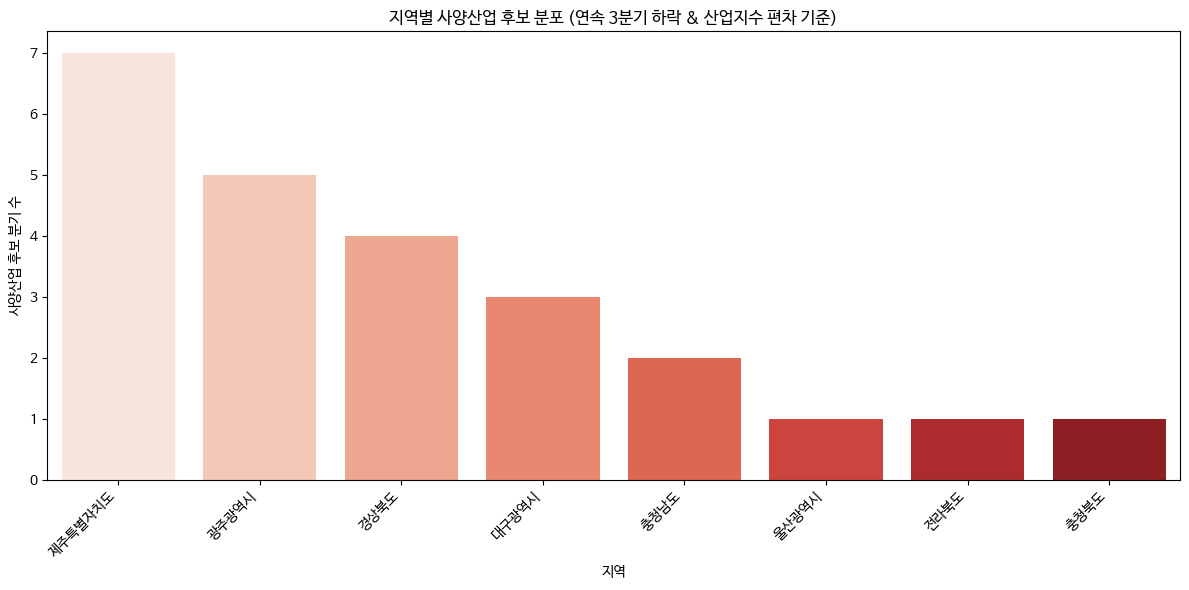

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 사양산업 후보 필터링
candidate_df = final[final['is_declining_candidate_m'] == True]

# 지역별 후보 수 집계
region_candidate_counts = candidate_df.groupby('sido').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=region_candidate_counts.index, y=region_candidate_counts.values, palette='Reds')
plt.title('지역별 사양산업 후보 분포')
plt.xlabel('지역')
plt.ylabel('사양산업 후보 분기 수')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/tmp/ipython-input-49-2152433768.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts.index, y=region_counts.values, palette='Reds')


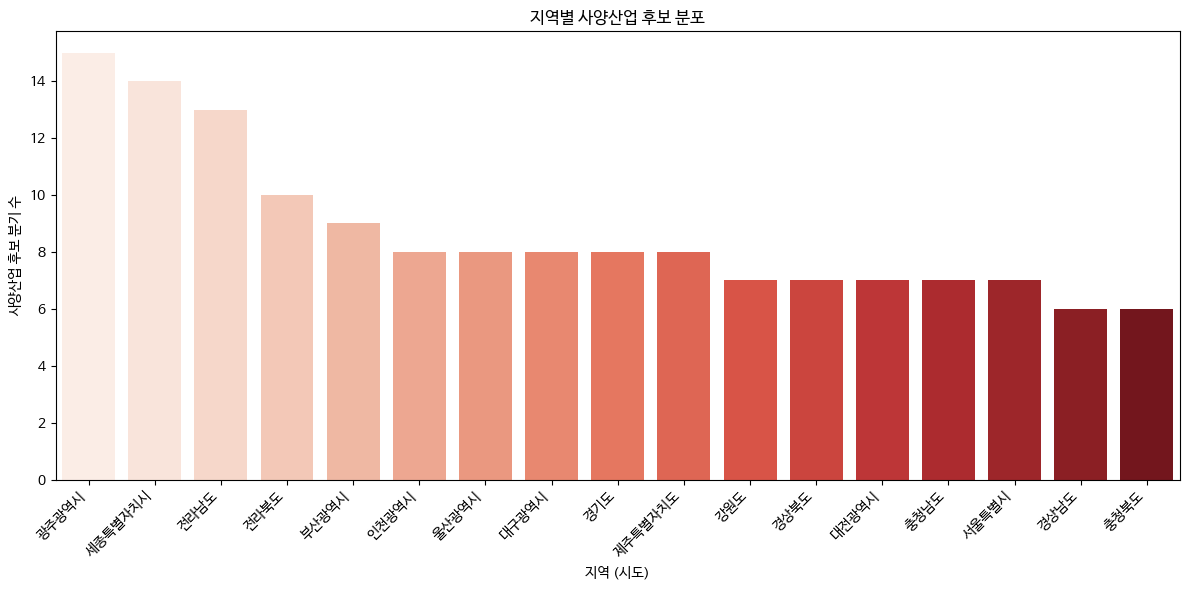

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 사양산업 후보 필터링
declining_candidates = df_labeled[df_labeled['is_declining'] == 1]

# 지역별 후보 수 집계
region_counts = declining_candidates['sido'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=region_counts.index, y=region_counts.values, palette='Reds')
plt.title('지역별 사양산업 후보 분포')
plt.xlabel('지역 (시도)')
plt.ylabel('사양산업 후보 분기 수')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 6-3. 최종 비교

In [ ]:
최종 = pd.read_csv('/content/drive/MyDrive/DScover/메인프로젝트/메인프로젝트/Main/ver/final_15_2.csv')
최종_ml = df_labeled.copy()

In [ ]:
# 1. 공통 key 기준으로 병합
merged = pd.merge(
    최종[['sido', 'industry_code', 'base_year_x', 'is_declining']],
    최종_ml[['sido', 'industry_code', 'base_year_x', 'is_declining']],
    on=['sido', 'industry_code', 'base_year_x'],
    suffixes=('_true', '_pred')
)

# 2. 일치 여부 컬럼 생성
merged['match'] = merged['is_declining_true'] == merged['is_declining_pred']

# 3. 일치율 계산
accuracy = merged['match'].mean()
print(f"is_declining 일치율: {accuracy:.4f} ({accuracy*100:.2f}%)")

# 선택적으로 confusion matrix 확인
from sklearn.metrics import confusion_matrix, classification_report

print("\n[Confusion Matrix]")
print(confusion_matrix(merged['is_declining_true'], merged['is_declining_pred']))

print("\n[Classification Report]")
print(classification_report(merged['is_declining_true'], merged['is_declining_pred'], zero_division=0))

is_declining 일치율: 0.9799 (97.99%)

[Confusion Matrix]
[[28038    85]
 [  493    99]]

[Classification Report]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     28123
           1       0.54      0.17      0.26       592

    accuracy                           0.98     28715
   macro avg       0.76      0.58      0.62     28715
weighted avg       0.97      0.98      0.97     28715



In [ ]:
# 1. 공통 key 기준으로 병합
merged = pd.merge(
    최종[['sido', 'industry_code', 'base_year_x', 'risk_level_5']],
    최종_ml[['sido', 'industry_code', 'base_year_x', 'risk_level_5']],
    on=['sido', 'industry_code', 'base_year_x'],
    suffixes=('_true', '_pred')
)

# 2. 일치 여부 컬럼 생성
merged['match'] = merged['risk_level_5_true'] == merged['risk_level_5_pred']

# 3. 일치율 계산
accuracy = merged['match'].mean()
print(f"✅ risk_level_5 일치율: {accuracy:.4f} ({accuracy*100:.2f}%)")

# 선택적으로 confusion matrix 확인
from sklearn.metrics import confusion_matrix, classification_report

print("\n[Confusion Matrix]")
print(confusion_matrix(merged['risk_level_5_true'], merged['risk_level_5_pred']))

print("\n[Classification Report]")
print(classification_report(merged['risk_level_5_true'], merged['risk_level_5_pred'], zero_division=0))


✅ risk_level_5 일치율: 0.6156 (61.56%)

[Confusion Matrix]
[[ 1878   411    26    72  1920]
 [  500  1919    51    64   338]
 [   66    31  1758   678   339]
 [  117    49   793  1860  1488]
 [ 1636   375   340  1743 10263]]

[Classification Report]
              precision    recall  f1-score   support

      Growth       0.45      0.44      0.44      4307
 High Growth       0.69      0.67      0.68      2872
   High Risk       0.59      0.61      0.60      2872
        Risk       0.42      0.43      0.43      4307
      Stable       0.72      0.71      0.72     14357

    accuracy                           0.62     28715
   macro avg       0.57      0.57      0.57     28715
weighted avg       0.62      0.62      0.62     28715

